In [1]:
# 2018-2022년 전국 아파트 실거래 정보

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import openpyxl
import numpy as np
import re
from sklearn.preprocessing import StandardScaler, normalize, RobustScaler, MinMaxScaler, FunctionTransformer
from scipy.stats import boxcox
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as hc
from sklearn.cluster import AgglomerativeClustering
from haversine import haversine, Unit

In [2]:
df1 = pd.read_csv('/home/subin/다운로드/여피/0308 업무-20230310T030110Z-001/0308 업무/complex_20230308 (사본).csv', header=None)
df1.columns = ['old_addr_idx', 'complex_name', 'property_type','시도', '시군구',
               '읍면동','리','road_name','road_code','admin_dong_code','postal_code','jibun_main','jibun_sub','updated']
df1.drop(['road_name','road_code','admin_dong_code','postal_code','jibun_main','jibun_sub', 'updated'], axis=1, inplace=True)

df1['시군구'] = df1['시군구'].str.split().str[0]
df1 = df1[df1['property_type']!='officetel']
df1.drop(['property_type'], axis=1, inplace=True)

In [3]:
df1

,old_addr_idx,complex_name,시도,시군구,읍면동,리
0,1111010100_00001_00000_apartment,청운벽산빌리지,서울특별시,종로구,청운동,NaN
1,1111010100_00003_00000_apartment,인텔빌라B C동,서울특별시,종로구,청운동,NaN
2,1111010100_00003_00150_apartment,인텔빌라A동,서울특별시,종로구,청운동,NaN
3,1111010100_00004_00001_apartment,아델하우스,서울특별시,종로구,청운동,NaN
4,1111010100_00004_00003_apartment,GRACETUSCANII,서울특별시,종로구,청운동,NaN
...,...,...,...,...,...,...
320920,5013032022_00048_00003_apartment,표선제이파크빌,제주특별자치도,서귀포시,표선면,하천리
320921,5013032022_02167_00000_apartment,지오화이트빌리지,제주특별자치도,서귀포시,표선면,하천리
320922,5013032023_02008_00000_apartment,보네르펜션,제주특별자치도,서귀포시,표선면,성읍리
320923,5013032024_02521_00005_apartment,(2521-5),제주특별자치도,서귀포시,표선면,가시리


In [4]:
df2 = pd.read_csv('/home/subin/다운로드/여피/0308 업무-20230310T030110Z-001/0308 업무/property_20230308.csv', header=None)
df2.columns = ['pk','old_addr_idx','dong','ho','official_price','net_leasable_area','updated']

In [5]:
app_apt = df2.merge(df1, on='old_addr_idx')
pd.options.display.max_columns = None
app_apt['평수'] = app_apt['net_leasable_area'] / 3.3
app_apt.drop(['net_leasable_area'], axis=1, inplace=True)
app_apt.replace('\\N', np.nan, inplace=True)
app_apt['시군구'] = app_apt['시군구'].fillna('세종특별자치시')

In [6]:
app_apt

,pk,old_addr_idx,dong,ho,official_price,updated,complex_name,시도,시군구,읍면동,리,평수
0,00000001_0001_0001,1111010100_00004_00007_apartment,단일,101,1249000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,63.978788
1,00000001_0001_0002,1111010100_00004_00007_apartment,단일,102,1076000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,63.396970
2,00000001_0001_0003,1111010100_00004_00007_apartment,단일,201,1140000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,62.996970
3,00000001_0001_0004,1111010100_00004_00007_apartment,단일,202,1249000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,65.178788
4,00000001_0001_0005,1111010100_00004_00007_apartment,단일,301,1332000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,66.463636
...,...,...,...,...,...,...,...,...,...,...,...,...
14496524,20432545_0001_0012,2647010200_01288_00036_apartment,A,404,43100000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394
14496525,20432545_0001_0013,2647010200_01288_00036_apartment,A,502,43300000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.630303
14496526,20432545_0001_0014,2647010200_01288_00036_apartment,A,504,42400000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394
14496527,20432545_0001_0015,2647010200_01288_00036_apartment,A,501,42400000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394


In [7]:
sido_list = app_apt['시도'].unique().tolist()
sido_list

['서울특별시',
 '부산광역시',
 '인천광역시',
 '경기도',
 '강원도',
 '충청북도',
 '세종특별자치시',
 '대전광역시',
 '충청남도',
 '전라북도',
 '광주광역시',
 '전라남도',
 '대구광역시',
 '경상북도',
 '경상남도',
 '울산광역시',
 '제주특별자치도']

In [8]:
app_apt['호']=app_apt['ho'].astype(str)

In [9]:
app_apt['호int'] = app_apt['호'].apply(lambda x: int(x) if x.isnumeric() else 0)

In [10]:
app_apt['호str'] = app_apt['호'].apply(lambda x: np.nan if x.isnumeric() else 0 if x.isdigit() else x)

In [11]:
app_apt

,pk,old_addr_idx,dong,ho,official_price,updated,complex_name,시도,시군구,읍면동,리,평수,호,호int,호str
0,00000001_0001_0001,1111010100_00004_00007_apartment,단일,101,1249000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,63.978788,101,101,NaN
1,00000001_0001_0002,1111010100_00004_00007_apartment,단일,102,1076000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,63.396970,102,102,NaN
2,00000001_0001_0003,1111010100_00004_00007_apartment,단일,201,1140000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,62.996970,201,201,NaN
3,00000001_0001_0004,1111010100_00004_00007_apartment,단일,202,1249000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,65.178788,202,202,NaN
4,00000001_0001_0005,1111010100_00004_00007_apartment,단일,301,1332000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,66.463636,301,301,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14496524,20432545_0001_0012,2647010200_01288_00036_apartment,A,404,43100000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394,404,404,NaN
14496525,20432545_0001_0013,2647010200_01288_00036_apartment,A,502,43300000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.630303,502,502,NaN
14496526,20432545_0001_0014,2647010200_01288_00036_apartment,A,504,42400000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394,504,504,NaN
14496527,20432545_0001_0015,2647010200_01288_00036_apartment,A,501,42400000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394,501,501,NaN


In [12]:
start = 100
step = 100
num_steps = 83
ranges1 = [(start + step * i, start + step * i + 10, i+1) for i in range(num_steps)]
labels1 = [r[2] for r in ranges1]
bins1 = [r[0] for r in ranges1] + [ranges1[-1][1]]

bins = bins1
labels = labels1

app_apt['층'] = pd.cut(app_apt['호int'], bins=bins, labels=labels, include_lowest=True, right=False)

In [13]:
floorSplit = app_apt[app_apt['호str'].str.contains('층')==True]

In [14]:
floorSplit['호str'] = floorSplit['호str'].str.split('층').str[0]

<ipython-input-14-5380e5940272>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floorSplit['호str'] = floorSplit['호str'].str.split('층').str[0]


In [15]:
floorSplit['호int'] = floorSplit['호str'].apply(lambda x: int(x) if x.isnumeric() else 0)

<ipython-input-15-fe789eedf5cc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floorSplit['호int'] = floorSplit['호str'].apply(lambda x: int(x) if x.isnumeric() else 0)


In [16]:
start = 100
step = 100
num_steps = 16
ranges = [(start + step * i, start + step * i + 10, i+1) for i in range(num_steps)]

labels = [r[2] for r in ranges]
bins = [r[0] for r in ranges] + [ranges[-1][1]]

floorSplit['층'] = pd.cut(floorSplit['호int'], bins=bins, labels=labels, include_lowest=True, right=False)

<ipython-input-16-9318b6f1daca>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floorSplit['층'] = pd.cut(floorSplit['호int'], bins=bins, labels=labels, include_lowest=True, right=False)


In [17]:
start1 = 1
step1 = 1
num_steps1 = 90
ranges2 = [(start1 + step1 * i, start1 + step1 * i + 0.1, i+1) for i in range(num_steps1)]
labels2 = [r[2] for r in ranges2]
bins2 = [r[0] for r in ranges2] + [ranges2[-1][1]]

# concatenate the two lists of bin edges and labels
bins = bins2
labels = labels2
# convert the '호int' column to a categorical column
floorSplit['층2'] = pd.cut(floorSplit['호int'], bins=bins, labels=labels, include_lowest=True, right=False)

<ipython-input-17-1196a492ffd3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floorSplit['층2'] = pd.cut(floorSplit['호int'], bins=bins, labels=labels, include_lowest=True, right=False)


In [18]:
codes = floorSplit['층'].cat.codes
codes2 = floorSplit['층2'].cat.codes
floorSplit['codes'] = codes.reindex(floorSplit.index)
floorSplit['codes2'] = codes2.reindex(floorSplit.index)
floorSplit['codes'].replace(-1, np.nan, inplace=True)
floorSplit['codes2'].replace(-1, np.nan, inplace=True)
floorSplit['codes'] = floorSplit['codes'] + 1
floorSplit['codes2'] = floorSplit['codes2'] + 1
floorSplit['codes'] = floorSplit['codes'].fillna(floorSplit['codes2'])
floorSplit.drop(['층', '층2', 'codes2'], axis=1, inplace=True)

<ipython-input-18-493d9e1025b8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floorSplit['codes'] = codes.reindex(floorSplit.index)
<ipython-input-18-493d9e1025b8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floorSplit['codes2'] = codes2.reindex(floorSplit.index)
<ipython-input-18-493d9e1025b8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

In [19]:
check = floorSplit[floorSplit['codes'].isnull()==True]

In [20]:
jiha = check[check['호str'].str.contains('지하')==True]
jiha['codes'] = -1
jiha = jiha[['pk', 'codes']]
check = check.merge(jiha, on=['pk'], how='left')
check = check.drop('codes_x', axis=1)
check = check.rename(columns={'codes_y':'codes'})

jisang = check[check['호str'].str.contains('지상')]
jisang['호str'] = jisang['호str'].str.split('지상').str[1]
jisang['codes'] = jisang['호str'].apply(lambda x: int(x) if x.isnumeric() else 0)

mask = (jisang['pk']=='11999085_0001_0001')
jisang.loc[mask, 'codes']=1
mask = (jisang['pk']=='12148950_0001_0002')
jisang.loc[mask, 'codes']=2
mask = (jisang['pk']=='12148950_0001_0004')
jisang.loc[mask, 'codes']=3
mask = (jisang['pk']=='12148950_0001_0005')
jisang.loc[mask, 'codes']=3
mask = (jisang['pk']=='12148950_0001_0006')
jisang.loc[mask, 'codes']=4

jisang = jisang[['pk', 'codes']]

check = check.merge(jisang, on=['pk'], how='left')
check['codes_x'] = check['codes_x'].fillna(check['codes_y'])
check = check.rename(columns={'codes_x':'codes'})
check.drop('codes_y', axis=1, inplace=True)

justJi = check[check['호str'].str.contains('지')&~(check['호str'].str.contains('지하'))&~(check['호str'].str.contains('지상'))]
justJi['codes'] = -1

justJi = justJi[['pk', 'codes']]

check = check.merge(justJi, on=['pk'], how='left')
check['codes_x'] = check['codes_x'].fillna(check['codes_y'])
check = check.rename(columns={'codes_x':'codes'})
check.drop('codes_y', axis=1, inplace=True)

<ipython-input-20-4e921100afe9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jiha['codes'] = -1
<ipython-input-20-4e921100afe9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jisang['호str'] = jisang['호str'].str.split('지상').str[1]
<ipython-input-20-4e921100afe9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [21]:
dong = check[(check['호str'].str.contains('동')==True) & (check['호str'].str.contains('지')!=True)]
dong['호str'] = dong['호str'].str.split('동').str[1]

mask = (dong['호str'].str.contains('3'))
dong.loc[mask, 'codes'] = 3
mask = (dong['호str'].str.contains('4'))
dong.loc[mask, 'codes'] = 4
mask = (dong['호str'].str.contains('일'))
dong.loc[mask, 'codes'] = 1
mask = (dong['호str'].str.contains('이'))
dong.loc[mask, 'codes'] = 2
mask = (dong['호str'].str.contains('삼'))
dong.loc[mask, 'codes'] = 3
mask = (dong['호str'].str.contains('사'))
dong.loc[mask, 'codes'] = 4
mask = (dong['호str'].str.contains('5'))
dong.loc[mask, 'codes'] = 5

mask = (dong['호str'].str.contains('1')) & (~dong['호str'].str.contains('2'))
dong.loc[mask, 'codes'] = 1
mask = (dong['호str'].str.contains('2')) & (~dong['호str'].str.contains('1'))
dong.loc[mask, 'codes'] = 2

mask = (dong['호str']=='10')
dong.loc[mask, 'codes'] = 10
mask = (dong['호str']=='11')
dong.loc[mask, 'codes'] = 11
mask = (dong['호str']=='12')
dong.loc[mask, 'codes'] = 12
mask = (dong['호str']=='13')
dong.loc[mask, 'codes'] = 13
mask = (dong['호str']=='14')
dong.loc[mask, 'codes'] = 14
mask = (dong['호str']=='15')
dong.loc[mask, 'codes'] = 15

mask = (dong['호str']=='2호1')
dong.loc[mask, 'codes'] = 1
mask = (dong['호str']=='1호2')
dong.loc[mask, 'codes'] = 2

dong = dong[['pk', 'codes']]

check = check.merge(dong, on='pk', how='left')
check['codes_x'] = check['codes_x'].fillna(check['codes_y'])
check = check.rename(columns={'codes_x':'codes'})
check.drop('codes_y', axis=1, inplace=True)

<ipython-input-21-9432fbcc790e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dong['호str'] = dong['호str'].str.split('동').str[1]


In [22]:
rest = check[check['codes'].isnull()==True]

regex = r'\D+(\d+)$'
rest['codes'] = rest['호str'].str.extract(regex)

rest_of_rest = rest[rest['codes'].isnull()==True]

mask = (rest_of_rest['호str'].str.contains('일'))
rest_of_rest.loc[mask, 'codes'] = 1
mask = (rest_of_rest['호str'].str.contains('이'))
rest_of_rest.loc[mask, 'codes'] = 2
mask = (rest_of_rest['호str'].str.contains('사'))
rest_of_rest.loc[mask, 'codes'] = 4
mask = (rest_of_rest['호str'].str.contains('삼'))
rest_of_rest.loc[mask, 'codes'] = 3
mask = (rest_of_rest['호str'].str.contains('오'))
rest_of_rest.loc[mask, 'codes'] = 5
mask = (rest_of_rest['호str'].str.contains('육'))
rest_of_rest.loc[mask, 'codes'] = 6
mask = (rest_of_rest['호str'].str.contains('칠'))
rest_of_rest.loc[mask, 'codes'] = 7

rest_of_rest_bok = rest_of_rest[rest_of_rest['codes'].isnull()==True]
rest_of_rest_bok = rest_of_rest[rest_of_rest['호str'].str.contains('복')]
rest_of_rest_bok['호str']= rest_of_rest_bok['호str'].str.split('복').str[0]

rest_of_rest_bok['numeric'] = rest_of_rest_bok['호str'].str.extract('(\d+)')
rest_of_rest_bok['numeric'] = rest_of_rest_bok['numeric'].fillna(0)
rest_of_rest_bok['numeric'] = rest_of_rest_bok['numeric'].astype(int)

start = 100
step = 100
num_steps = 16
ranges = [(start + step * i, start + step * i + 10, i+1) for i in range(num_steps)]

labels = [r[2] for r in ranges]
bins = [r[0] for r in ranges] + [ranges[-1][1]]

rest_of_rest_bok['층'] = pd.cut(rest_of_rest_bok['numeric'], bins=bins, labels=labels, include_lowest=True, right=False)



<ipython-input-22-3e2152d64c0e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest['codes'] = rest['호str'].str.extract(regex)
<ipython-input-22-3e2152d64c0e>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_rest_bok['호str']= rest_of_rest_bok['호str'].str.split('복').str[0]
<ipython-input-22-3e2152d64c0e>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

In [23]:
codes3 = rest_of_rest_bok['층'].cat.codes
rest_of_rest_bok['codes3'] = codes3.reindex(rest_of_rest_bok.index)
rest_of_rest_bok['codes3'].replace(-1, np.nan, inplace=True)
rest_of_rest_bok['codes3'] = rest_of_rest_bok['codes3'] + 1
rest_of_rest_bok.drop(['codes', 'numeric', '층'], axis=1, inplace=True)
rest_of_rest_bok = rest_of_rest_bok.rename(columns={'codes3':'codes'})
rest_of_rest_bok = rest_of_rest_bok[['pk', 'codes']]

rest_of_rest = rest_of_rest.merge(rest_of_rest_bok, on='pk', how='left')
rest_of_rest['codes_x'] = rest_of_rest['codes_x'].fillna(rest_of_rest['codes_y'])
rest_of_rest = rest_of_rest.rename(columns={'codes_x':'codes'})
rest_of_rest.drop('codes_y', axis=1, inplace=True)

mask = (rest_of_rest['codes']==0)
rest_of_rest.loc[mask, 'codes'] = 3

<ipython-input-23-1b9d5dade8fd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_rest_bok['codes3'] = codes3.reindex(rest_of_rest_bok.index)
<ipython-input-23-1b9d5dade8fd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_rest_bok['codes3'].replace(-1, np.nan, inplace=True)
<ipython-input-23-1b9d5dade8fd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [24]:
rest_of_rest_ = rest_of_rest[rest_of_rest['codes'].isnull()==True]

mask = (rest_of_rest_['ho'].str.contains('별층'))
rest_of_rest_.loc[mask, 'codes'] = -1
mask = (rest_of_rest_['ho'].str.contains('비층'))
rest_of_rest_.loc[mask, 'codes'] = -1
mask = (rest_of_rest_['ho'].str.contains('B'))
rest_of_rest_.loc[mask, 'codes'] = -1
mask = (rest_of_rest_['ho'].str.contains('401'))
rest_of_rest_.loc[mask, 'codes'] = 4
mask = (rest_of_rest_['ho'].str.contains('402'))
rest_of_rest_.loc[mask, 'codes'] = 4
mask = (rest_of_rest_['ho'].str.contains('201'))
rest_of_rest_.loc[mask, 'codes'] = 2
mask = (rest_of_rest_['ho'].str.contains('202'))
rest_of_rest_.loc[mask, 'codes'] = 2

mask = (rest_of_rest_['pk']=='12085035_0001_0004')
rest_of_rest_.loc[mask, 'codes'] = 4

rest_of_rest_ = rest_of_rest_[['pk', 'codes']]

rest_of_rest = rest_of_rest.merge(rest_of_rest_, on='pk', how='left')
rest_of_rest['codes_x'] = rest_of_rest['codes_x'].fillna(rest_of_rest['codes_y'])
rest_of_rest = rest_of_rest.rename(columns={'codes_x':'codes'})
rest_of_rest.drop('codes_y', axis=1, inplace=True)

rest_of_rest = rest_of_rest[['pk', 'codes']]
rest = rest.merge(rest_of_rest, on='pk', how='left')
rest['codes_x'] = rest['codes_x'].fillna(rest['codes_y'])
rest = rest.rename(columns={'codes_x':'codes'})
rest.drop('codes_y', axis=1, inplace=True)

rest = rest[['pk', 'codes']]
check = check.merge(rest, on='pk', how='left')
check['codes_x'] = check['codes_x'].fillna(check['codes_y'])
check = check.rename(columns={'codes_x':'codes'})
check.drop('codes_y', axis=1, inplace=True)

check = check[['pk', 'codes']]
floorSplit = floorSplit.merge(check, on='pk', how='left')
floorSplit['codes_x'] = floorSplit['codes_x'].fillna(floorSplit['codes_y'])
floorSplit = floorSplit.rename(columns={'codes_x':'codes'})
floorSplit.drop('codes_y', axis=1, inplace=True)

mask = (floorSplit['pk']=='12030365_0001_0005')
floorSplit.loc[mask, 'codes'] = 3
mask = (floorSplit['pk']=='12035834_0001_0003')
floorSplit.loc[mask, 'codes'] = 3

In [25]:
codes4 = app_apt['층'].cat.codes
app_apt['codes'] = codes4.reindex(app_apt.index)
app_apt['codes'] = app_apt['codes'] + 1
app_apt['codes'].replace(0, np.nan, inplace=True)

floorSplit = floorSplit[['pk', 'codes']]
app_apt = app_apt.merge(floorSplit, on='pk', how='left')
app_apt['codes_x'] = app_apt['codes_x'].fillna(app_apt['codes_y'])
app_apt = app_apt.rename(columns={'codes_x':'codes'})
app_apt.drop('codes_y', axis=1, inplace=True)

In [26]:
last = app_apt[app_apt['codes'].isnull()==True]
last.drop(['호int', '호str', '층'], axis=1, inplace=True)

<ipython-input-26-a88709004904>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last.drop(['호int', '호str', '층'], axis=1, inplace=True)


In [27]:
last['codes'].info()

<class 'pandas.core.series.Series'>
Int64Index: 230837 entries, 6 to 14495298
Series name: codes
Non-Null Count  Dtype 
--------------  ----- 
0 non-null      object
dtypes: object(1)
memory usage: 3.5+ MB


In [28]:
jiha2 = last[last['호'].str.contains('지하')==True]
jiha2['codes'] = -1
jiha2 = jiha2[['pk', 'codes']]
last = last.merge(jiha2, on=['pk'], how='left')
last = last.drop('codes_x', axis=1)
last = last.rename(columns={'codes_y':'codes'})

<ipython-input-28-c4a92d2f4a90>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jiha2['codes'] = -1


In [29]:
jisang2 = last[last['호'].str.contains('지상')]
jisang2['호'] = jisang2['호'].str.split('지상').str[1]

<ipython-input-29-25076aa31f93>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jisang2['호'] = jisang2['호'].str.split('지상').str[1]


In [30]:
jisang2['numeric'] = jisang2['호'].str.extract('(\d+)')
jisang2['numeric'] = jisang2['numeric'].fillna(0)
jisang2['numeric'] = jisang2['numeric'].astype(int)

start = 100
step = 100
num_steps = 18
ranges = [(start + step * i, start + step * i + 10, i+1) for i in range(num_steps)]

labels = [r[2] for r in ranges]
bins = [r[0] for r in ranges] + [ranges[-1][1]]

jisang2['층'] = pd.cut(jisang2['numeric'], bins=bins, labels=labels, include_lowest=True, right=False)

start1 = 1
step1 = 1
num_steps1 = 90
ranges2 = [(start1 + step1 * i, start1 + step1 * i + 0.1, i+1) for i in range(num_steps1)]
labels2 = [r[2] for r in ranges2]
bins2 = [r[0] for r in ranges2] + [ranges2[-1][1]]

# concatenate the two lists of bin edges and labels
bins = bins2
labels = labels2
# convert the 'numeric' column to a categorical column
jisang2['층2'] = pd.cut(jisang2['numeric'], bins=bins, labels=labels, include_lowest=True, right=False)

codes = jisang2['층'].cat.codes
codes2 = jisang2['층2'].cat.codes
jisang2['codes'] = codes.reindex(jisang2.index)
jisang2['codes2'] = codes2.reindex(jisang2.index)
jisang2['codes'].replace(-1, np.nan, inplace=True)
jisang2['codes2'].replace(-1, np.nan, inplace=True)
jisang2['codes'] = jisang2['codes'] + 1
jisang2['codes2'] = jisang2['codes2'] + 1
jisang2['codes'] = jisang2['codes'].fillna(jisang2['codes2'])
jisang2.drop(['층', '층2', 'codes2', 'numeric'], axis=1, inplace=True)

mask = (jisang2['pk']=='20031264_0001_0001')
jisang2.loc[mask, 'codes'] = 1

<ipython-input-30-4e5c74641632>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jisang2['numeric'] = jisang2['호'].str.extract('(\d+)')
<ipython-input-30-4e5c74641632>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jisang2['numeric'] = jisang2['numeric'].fillna(0)
<ipython-input-30-4e5c74641632>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [31]:
last

,pk,old_addr_idx,dong,ho,official_price,updated,complex_name,시도,시군구,읍면동,리,평수,호,codes
0,00000001_0001_0007,1111010100_00004_00007_apartment,단일,B02,390000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,27.490909,B02,NaN
1,00000001_0001_0008,1111010100_00004_00007_apartment,단일,B01,524000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,35.990909,B01,NaN
2,00000002_0001_0001,1111010100_00003_00000_apartment,비,1,1382000000,2021-01-01,인텔빌라B C동,서울특별시,종로구,청운동,NaN,70.927273,1,NaN
3,00000002_0001_0002,1111010100_00003_00000_apartment,비,10,1391000000,2021-01-01,인텔빌라B C동,서울특별시,종로구,청운동,NaN,70.745455,10,NaN
4,00000002_0001_0003,1111010100_00003_00000_apartment,비,2,1382000000,2021-01-01,인텔빌라B C동,서울특별시,종로구,청운동,NaN,70.800000,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230832,20430554_0002_0019,4146125321_00531_00005_apartment,102,B03,254000000,2021-12-01,모드니타운,경기도,용인시,모현읍,왕산리,25.283909,B03,NaN
230833,20430554_0002_0020,4146125321_00531_00005_apartment,102,B04,254000000,2021-12-01,모드니타운,경기도,용인시,모현읍,왕산리,25.283909,B04,NaN
230834,20431047_0001_0009,4161025322_00277_00007_apartment,101,B02,216000000,2021-10-01,T.S크라이시Ⅲ,경기도,광주시,초월읍,쌍동리,25.374242,B02,NaN
230835,20431216_0001_0001,4122025042_00088_00000_apartment,A,A,573000000,2021-06-01,WoodenBreeze,경기도,평택시,팽성읍,동창리,82.887879,A,NaN


In [32]:
jisang2 = jisang2[['pk', 'codes']]
last = last.merge(jisang2, on='pk', how='left')
last['codes_x'] = last['codes_x'].fillna(last['codes_y'])
last = last.rename(columns={'codes_x':'codes'})
last.drop('codes_y', axis=1, inplace=True)

In [33]:
last['codes'].info()

<class 'pandas.core.series.Series'>
Int64Index: 230837 entries, 0 to 230836
Series name: codes
Non-Null Count  Dtype  
--------------  -----  
9511 non-null   float64
dtypes: float64(1)
memory usage: 3.5 MB


In [34]:
last = last[['pk', 'codes']]
last = last.dropna(subset='codes')
app_apt = app_apt.merge(last, on='pk', how='left')
app_apt['codes_x'] = app_apt['codes_x'].fillna(app_apt['codes_y'])
app_apt = app_apt.rename(columns={'codes_x':'codes'})
app_apt.drop('codes_y', axis=1, inplace=True)

In [35]:
app_apt_match = app_apt[['old_addr_idx', 'official_price', '시도', '시군구', '읍면동', '리', '평수', 'codes']]

In [36]:
###########################################                                         ###################################
##############################################    공시지가 층수 작업 미완료 !!!    #############################################
###########################################       공시지가 층수 작업 미완료 !!!      #######################################
#########################################                                           ###############################################

pd.set_option('display.max_rows', 10)

In [37]:
last2 = app_apt[app_apt['codes'].isnull()==True]

In [38]:
last2['numeric'] = last2['호'].str.extract('(\d+)')
last2['numeric'] = last2['numeric'].fillna(0)
last2['numeric'] = last2['numeric'].astype(int)

start = 100
step = 100
num_steps = 50
ranges = [(start + step * i, start + step * i + 10, i+1) for i in range(num_steps)]

labels = [r[2] for r in ranges]
bins = [r[0] for r in ranges] + [ranges[-1][1]]

last2['층'] = pd.cut(last2['numeric'], bins=bins, labels=labels, include_lowest=True, right=False)

<ipython-input-38-7494bad5c2f2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last2['numeric'] = last2['호'].str.extract('(\d+)')
<ipython-input-38-7494bad5c2f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last2['numeric'] = last2['numeric'].fillna(0)
<ipython-input-38-7494bad5c2f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [39]:
mask = (last2['numeric']==0)
last2.loc[mask, 'numeric'] = 1

In [40]:
mask = (last2['호'].str.contains('B0'))
last2.loc[mask, 'numeric'] = -1

In [41]:
codes5 = last2['층'].cat.codes
last2['codes2'] = codes.reindex(last2.index)
last2['codes2'].replace(-1, np.nan, inplace=True)
last2['codes2'] = last2['codes2'] + 1
last2['codes'] = last2['codes'].fillna(last2['codes2'])
last2['codes'] = last2['codes'].fillna(last2['numeric'])
last2.drop(['층','codes2', 'numeric'], axis=1, inplace=True)

<ipython-input-41-924028124f2b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last2['codes2'] = codes.reindex(last2.index)
<ipython-input-41-924028124f2b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last2['codes2'].replace(-1, np.nan, inplace=True)
<ipython-input-41-924028124f2b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [42]:
last2

,pk,old_addr_idx,dong,ho,official_price,updated,complex_name,시도,시군구,읍면동,리,평수,호,호int,호str,codes
6,00000001_0001_0007,1111010100_00004_00007_apartment,단일,B02,390000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,27.490909,B02,0,B02,-1.0
7,00000001_0001_0008,1111010100_00004_00007_apartment,단일,B01,524000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,35.990909,B01,0,B01,-1.0
8,00000002_0001_0001,1111010100_00003_00000_apartment,비,1,1382000000,2021-01-01,인텔빌라B C동,서울특별시,종로구,청운동,NaN,70.927273,1,1,NaN,1.0
9,00000002_0001_0002,1111010100_00003_00000_apartment,비,10,1391000000,2021-01-01,인텔빌라B C동,서울특별시,종로구,청운동,NaN,70.745455,10,10,NaN,10.0
10,00000002_0001_0003,1111010100_00003_00000_apartment,비,2,1382000000,2021-01-01,인텔빌라B C동,서울특별시,종로구,청운동,NaN,70.800000,2,2,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14482716,20430554_0002_0019,4146125321_00531_00005_apartment,102,B03,254000000,2021-12-01,모드니타운,경기도,용인시,모현읍,왕산리,25.283909,B03,0,B03,-1.0
14482717,20430554_0002_0020,4146125321_00531_00005_apartment,102,B04,254000000,2021-12-01,모드니타운,경기도,용인시,모현읍,왕산리,25.283909,B04,0,B04,-1.0
14493054,20431047_0001_0009,4161025322_00277_00007_apartment,101,B02,216000000,2021-10-01,T.S크라이시Ⅲ,경기도,광주시,초월읍,쌍동리,25.374242,B02,0,B02,-1.0
14495297,20431216_0001_0001,4122025042_00088_00000_apartment,A,A,573000000,2021-06-01,WoodenBreeze,경기도,평택시,팽성읍,동창리,82.887879,A,0,A,1.0


In [43]:
last2 = last2[['pk', 'codes']]
app_apt = app_apt.merge(last2, on='pk', how='left')
app_apt['codes_x'] = app_apt['codes_x'].fillna(app_apt['codes_y'])
app_apt = app_apt.rename(columns={'codes_x':'codes'})
app_apt.drop('codes_y', axis=1, inplace=True)

In [44]:
app_apt

,pk,old_addr_idx,dong,ho,official_price,updated,complex_name,시도,시군구,읍면동,리,평수,호,호int,호str,층,codes
0,00000001_0001_0001,1111010100_00004_00007_apartment,단일,101,1249000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,63.978788,101,101,NaN,1,1.0
1,00000001_0001_0002,1111010100_00004_00007_apartment,단일,102,1076000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,63.396970,102,102,NaN,1,1.0
2,00000001_0001_0003,1111010100_00004_00007_apartment,단일,201,1140000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,62.996970,201,201,NaN,2,2.0
3,00000001_0001_0004,1111010100_00004_00007_apartment,단일,202,1249000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,65.178788,202,202,NaN,2,2.0
4,00000001_0001_0005,1111010100_00004_00007_apartment,단일,301,1332000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,66.463636,301,301,NaN,3,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14496524,20432545_0001_0012,2647010200_01288_00036_apartment,A,404,43100000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394,404,404,NaN,4,4.0
14496525,20432545_0001_0013,2647010200_01288_00036_apartment,A,502,43300000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.630303,502,502,NaN,5,5.0
14496526,20432545_0001_0014,2647010200_01288_00036_apartment,A,504,42400000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394,504,504,NaN,5,5.0
14496527,20432545_0001_0015,2647010200_01288_00036_apartment,A,501,42400000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394,501,501,NaN,5,5.0


In [45]:
app_apt_match = app_apt[['old_addr_idx', 'official_price', '시도', '시군구', '읍면동', '리', '평수', 'codes']]
app_apt_match = app_apt_match.rename(columns={'codes':'층수', 'official_price':'공시지가'})
app_apt_match = app_apt_match.drop_duplicates()

In [46]:
app_apt_match

,old_addr_idx,공시지가,시도,시군구,읍면동,리,평수,층수
0,1111010100_00004_00007_apartment,1249000000,서울특별시,종로구,청운동,NaN,63.978788,1.0
1,1111010100_00004_00007_apartment,1076000000,서울특별시,종로구,청운동,NaN,63.396970,1.0
2,1111010100_00004_00007_apartment,1140000000,서울특별시,종로구,청운동,NaN,62.996970,2.0
3,1111010100_00004_00007_apartment,1249000000,서울특별시,종로구,청운동,NaN,65.178788,2.0
4,1111010100_00004_00007_apartment,1332000000,서울특별시,종로구,청운동,NaN,66.463636,3.0
...,...,...,...,...,...,...,...,...
14496518,2647010200_01288_00036_apartment,43100000,부산광역시,연제구,연산동,NaN,5.539394,3.0
14496521,2647010200_01288_00036_apartment,43900000,부산광역시,연제구,연산동,NaN,5.630303,4.0
14496523,2647010200_01288_00036_apartment,43100000,부산광역시,연제구,연산동,NaN,5.539394,4.0
14496525,2647010200_01288_00036_apartment,43300000,부산광역시,연제구,연산동,NaN,5.630303,5.0


In [47]:
daegu = app_apt_match[app_apt_match['시도']=='강원도']

In [48]:
daegu

,old_addr_idx,공시지가,시도,시군구,읍면동,리,평수,층수
2768436,4211010800_00034_00000_apartment,69700000,강원도,춘천시,조양동,NaN,16.833333,10.0
2768437,4211010800_00034_00000_apartment,105000000,강원도,춘천시,조양동,NaN,25.709091,10.0
2768447,4211010800_00034_00000_apartment,69700000,강원도,춘천시,조양동,NaN,16.833333,11.0
2768448,4211010800_00034_00000_apartment,105000000,강원도,춘천시,조양동,NaN,25.709091,11.0
2768458,4211010800_00034_00000_apartment,69700000,강원도,춘천시,조양동,NaN,16.833333,12.0
...,...,...,...,...,...,...,...,...
14494581,4223010700_00102_00001_apartment,187000000,강원도,삼척시,갈천동,NaN,25.638576,24.0
14494585,4223010700_00102_00001_apartment,589000000,강원도,삼척시,갈천동,NaN,43.541697,25.0
14494687,4223010700_00102_00001_apartment,187000000,강원도,삼척시,갈천동,NaN,25.638576,25.0
14494691,4223010700_00102_00001_apartment,187000000,강원도,삼척시,갈천동,NaN,25.638576,26.0


In [49]:
areaCode = pd.read_excel('/home/subin/다운로드/행정_법정동 중심좌표_동별.xlsx')
areaCode = areaCode[areaCode['코드종류']=='B']
areaCode.drop(['코드', '코드종류'], axis=1, inplace=True)
areaCode['시군구'] = areaCode['시군구'].str.split().str[0]

In [50]:
areaCodeMain = areaCode[areaCode['시도']=='강원도']

In [51]:
areaCodeMain

,시도,시군구,읍면동,리,위도,경도
7473,강원도,춘천시,봉의동,NaN,37.885256,127.731315
7474,강원도,춘천시,요선동,NaN,37.882638,127.727821
7475,강원도,춘천시,낙원동,NaN,37.879211,127.724034
7476,강원도,춘천시,중앙로1가,NaN,37.881981,127.728769
7477,강원도,춘천시,중앙로2가,NaN,37.878931,127.726056
...,...,...,...,...,...,...
8745,강원도,양양군,강현면,장산리,38.139630,128.591513
8746,강원도,양양군,강현면,전진리,38.122975,128.627998
8747,강원도,양양군,강현면,주청리,38.116942,128.629349
8748,강원도,양양군,강현면,적은리,38.117936,128.597434


In [52]:
daegu =daegu.merge(areaCodeMain, on=['시도', '시군구', '읍면동', '리'], how='left')

In [53]:
daegu

,old_addr_idx,공시지가,시도,시군구,읍면동,리,평수,층수,위도,경도
0,4211010800_00034_00000_apartment,69700000,강원도,춘천시,조양동,NaN,16.833333,10.0,37.879798,127.730261
1,4211010800_00034_00000_apartment,105000000,강원도,춘천시,조양동,NaN,25.709091,10.0,37.879798,127.730261
2,4211010800_00034_00000_apartment,69700000,강원도,춘천시,조양동,NaN,16.833333,11.0,37.879798,127.730261
3,4211010800_00034_00000_apartment,105000000,강원도,춘천시,조양동,NaN,25.709091,11.0,37.879798,127.730261
4,4211010800_00034_00000_apartment,69700000,강원도,춘천시,조양동,NaN,16.833333,12.0,37.879798,127.730261
...,...,...,...,...,...,...,...,...,...,...
66413,4223010700_00102_00001_apartment,187000000,강원도,삼척시,갈천동,NaN,25.638576,24.0,37.465218,129.164438
66414,4223010700_00102_00001_apartment,589000000,강원도,삼척시,갈천동,NaN,43.541697,25.0,37.465218,129.164438
66415,4223010700_00102_00001_apartment,187000000,강원도,삼척시,갈천동,NaN,25.638576,25.0,37.465218,129.164438
66416,4223010700_00102_00001_apartment,187000000,강원도,삼척시,갈천동,NaN,25.638576,26.0,37.465218,129.164438


In [54]:
mask = (daegu['시도'] == '강원도') & (daegu['읍면동'] == '국토정중앙면') & (daegu['리'] == '용하리')
daegu.loc[mask, '위도'] = areaCode.iloc[4939, 4]
daegu.loc[mask, '경도'] = areaCode.iloc[4939, 5]

code = areaCode[areaCode['시도']=='강원도']

mean_by_sigungu = code.groupby(['시도', '시군구']).mean().reset_index()
code = pd.concat([code, mean_by_sigungu], ignore_index=True)
code = code.sort_values(['시도', '시군구'])

daegu = code.set_index(['시도', '시군구', '읍면동', '리']).combine_first(daegu.set_index(['시도', '시군구', '읍면동', '리'])).reset_index()
daegu = daegu.dropna(subset='공시지가')

<ipython-input-54-4b8fc182535f>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_by_sigungu = code.groupby(['시도', '시군구']).mean().reset_index()


In [55]:
daegu

,시도,시군구,읍면동,리,old_addr_idx,경도,공시지가,위도,층수,평수
1,강원도,강릉시,강동면,산성우리,4215034030_00219_00000_apartment,129.014238,26000000.0,37.676072,2.0,6.803030
2,강원도,강릉시,강동면,산성우리,4215034030_00219_00000_apartment,129.014238,31500000.0,37.676072,2.0,8.287879
3,강원도,강릉시,강동면,산성우리,4215034030_00219_00000_apartment,129.014238,26000000.0,37.676072,3.0,6.803030
4,강원도,강릉시,강동면,산성우리,4215034030_00219_00000_apartment,129.014238,31500000.0,37.676072,3.0,8.287879
5,강원도,강릉시,강동면,산성우리,4215034030_00219_00000_apartment,129.014238,26000000.0,37.676072,4.0,6.803030
...,...,...,...,...,...,...,...,...,...,...
67361,강원도,횡성군,NaN,NaN,4273025022_00347_00003_apartment,128.058482,24200000.0,37.510619,3.0,18.100000
67362,강원도,횡성군,NaN,NaN,4273032021_00352_00012_apartment,128.058482,30900000.0,37.510619,1.0,18.163636
67363,강원도,횡성군,NaN,NaN,4273032021_00352_00012_apartment,128.058482,32100000.0,37.510619,2.0,18.163636
67364,강원도,횡성군,NaN,NaN,4273032021_00352_00012_apartment,128.058482,32100000.0,37.510619,3.0,18.163636


In [56]:
daegu_name = daegu[['old_addr_idx', '위도', '경도']]
daegu_name = daegu_name.drop_duplicates()
daegu_name['위도+경도'] = daegu_name['위도'].astype(str) + daegu_name['경도'].astype(str)

In [57]:
daeguArea = daegu[['위도', '경도']]
daeguArea = daeguArea.drop_duplicates()
daeguArea['위도+경도'] = daeguArea['위도'].astype(str) + daeguArea['경도'].astype(str)

In [58]:
school = pd.read_excel('/home/subin/다운로드/전국초중등학교위치표준데이터-20230404.xls')
school.rename(columns=school.iloc[0], inplace=True)
school = school.drop(0)

school['시도']=school['시도교육청명'].str.split('교육청').str[0]
school.drop(['시도교육청명', '제공기관명', '생성일자', '변경일자', '교육지원청명', '데이터기준일자','소재지지번주소', '소재지도로명주소', '설립일자',
             '학교ID', '제공기관코드', '시도교육청코드', '교육지원청코드', '운영상태'], axis=1, inplace=True)
school['학교급구분'] = school['학교급구분'].str.split('학교').str[0]

school['위도'] = school['위도'].astype(float).round(6)
school['경도'] = school['경도'].astype(float).round(6)

In [59]:
school_daegu = school[school['시도']=='강원도']
school_daegu

,학교명,학교급구분,설립형태,본교분교구분,위도,경도,시도
4,간성초등학교,초등,공립,본교,38.377306,128.468733,강원도
5,모산초등학교,초등,공립,본교,37.731840,128.901781,강원도
23,소양고등학교,고등,공립,본교,37.910016,127.723294,강원도
41,묘장초등학교,초등,공립,본교,38.264086,127.164803,강원도
45,동명초등학교,초등,공립,본교,37.775431,128.928745,강원도
...,...,...,...,...,...,...,...
11901,봄내중학교,중,공립,본교,37.865468,127.740764,강원도
11902,육민관고등학교,고등,사립,본교,37.309364,127.918486,강원도
11984,상장중학교,중,공립,본교,37.150686,128.992122,강원도
11985,맹방초등학교,초등,공립,본교,37.398527,129.212777,강원도


In [60]:
school_ele = school_daegu[school_daegu['학교급구분']=='초등']
school_mid = school_daegu[school_daegu['학교급구분']=='중']
school_high = school_daegu[school_daegu['학교급구분']=='고등']

In [61]:
school_daeguArea= school_daegu.drop(['학교급구분', '설립형태', '본교분교구분', '시도'], axis=1)
school_eleArea = school_ele.drop(['학교급구분', '설립형태', '본교분교구분', '시도'], axis=1)
school_midArea = school_mid.drop(['학교급구분', '설립형태', '본교분교구분', '시도'], axis=1)
school_highArea = school_high.drop(['학교급구분', '설립형태', '본교분교구분', '시도'], axis=1)

In [62]:
ktx = pd.read_excel('/home/subin/다운로드/기차역.ods', engine='odf', header=None)
ktx.columns = ['역사명', '주소', '노선', '지역권', '역사명_폐여부', '위도', '경도']
ktx = ktx[ktx['역사명_폐여부'].str.contains('(폐역)') == False]
ktx

<ipython-input-62-d5df2082c847>:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ktx = ktx[ktx['역사명_폐여부'].str.contains('(폐역)') == False]


,역사명,주소,노선,지역권,역사명_폐여부,위도,경도
0,서울,서울시 용산구 한강대로 405 (동자동 43-205),경부선,경부선,서울역,37.554679,126.970607
1,행신,경기도 고양시 덕양구 소원로 102,경의선,경부선,행신역,37.611971,126.834290
2,영등포,서울시 영등포구 경인로 846,경부선,경부선,영등포역,37.515684,126.907876
3,광명,경기도 광명시 광명역로 21(일직동),경부고속,경부선,광명역,37.416451,126.884804
4,수원,경기도 수원시 팔달구 덕영대로 924 수원역,경부선,경부선,수원역,37.265790,127.000095
...,...,...,...,...,...,...,...
440,오수,전북 임실군 오수면 충효로 1967-19,전라선,전라권,오수역,35.542953,127.320547
441,안평,전라남도 장성군 장성읍 잠암길 7,호남선,전라권,안평역,35.333951,126.780271
443,감곡,전북 정읍시 감곡면 호남철로 501,호남선,전라권,감곡역,35.733280,126.897655
446,곡성,전남 곡성군 곡성읍 곡성로 920,전라선,전라권,곡성역,35.283659,127.303702


In [63]:
expressBus = pd.read_excel('/home/subin/다운로드/고속버스터미널.ods', engine='odf', header=None)
expressBus['경도'] = expressBus[0].str.split(',').str[0]
expressBus['위도'] = expressBus[0].str.split(',').str[1]
expressBus['정류소명'] = expressBus[0].str.split(',').str[2]
expressBus['주소'] = expressBus[0].str.split(',').str[3]
expressBus.drop([0, '주소'], axis=1, inplace=True)
expressBus['경도'] = expressBus['경도'].astype(float).round(6)
expressBus['위도'] = expressBus['위도'].astype(float).round(6)
expressBus

# https://ciy545.tistory.com/333
# https://ciy545.tistory.com/294

,경도,위도,정류소명
0,127.094062,37.534394,동서울종합터미널
1,127.092703,37.596137,상봉터미널
2,127.005846,37.505681,서울고속버스터미널
3,127.015578,37.484535,서울남부터미널
4,127.003213,37.504918,센트럴시티터미널
...,...,...,...
128,128.605781,36.827080,영주종합터미널
129,128.927555,35.960636,영천버스터미널
130,129.008853,35.918664,임포공용버스터미널
131,128.192360,36.586097,점촌시외고속버스터미널


In [64]:
outBus = pd.read_excel('/home/subin/다운로드/시외버스터미널.ods', engine='odf', header=None)
outBus['경도'] = outBus[0].str.split(',').str[0]
outBus['위도'] = outBus[0].str.split(',').str[1]
outBus['정류소명'] = outBus[0].str.split(',').str[2]
outBus['주소'] = outBus[0].str.split(',').str[3]
outBus.drop([0, '주소'], axis=1, inplace=True)
outBus['경도'] = outBus['경도'].astype(float).round(6)
outBus['위도'] = outBus['위도'].astype(float).round(6)
outBus

,경도,위도,정류소명
0,127.117254,37.494291,가락시장역정류소
1,126.802351,37.560307,김포공항정류소
2,127.059674,37.657153,도봉면허시험장정류소
3,127.094062,37.534394,동서울종합터미널
4,126.981446,37.475206,사당역시외버스정류소
...,...,...,...
664,127.948640,36.443712,화령정류소
665,127.917066,36.564119,화북정류소
666,128.755128,36.125843,화수정류소
667,128.586538,36.155955,효령정류소


In [65]:
bus = pd.concat([expressBus, outBus], axis=0)
bus

,경도,위도,정류소명
0,127.094062,37.534394,동서울종합터미널
1,127.092703,37.596137,상봉터미널
2,127.005846,37.505681,서울고속버스터미널
3,127.015578,37.484535,서울남부터미널
4,127.003213,37.504918,센트럴시티터미널
...,...,...,...
664,127.948640,36.443712,화령정류소
665,127.917066,36.564119,화북정류소
666,128.755128,36.125843,화수정류소
667,128.586538,36.155955,효령정류소


In [107]:
from scipy.spatial.distance import cdist
housing_coords = daeguArea[['위도', '경도']].values
bus_coords = bus[['위도', '경도']].values
distances_matrix = cdist(housing_coords, bus_coords, metric=haversine)
distances_df = pd.DataFrame(distances_matrix, columns=bus['정류소명'], index=daeguArea['위도+경도'])
distances_df = distances_df.reset_index().melt(id_vars='위도+경도', var_name='bus_id', value_name='distance')

In [67]:
distances_df.groupby(['위도+경도', 'bus_id']).min().reset_index().describe()

,distance
count,252648.000000
mean,186.076046
std,94.872059
min,0.040939
25%,113.040406
50%,176.062956
75%,248.833041
max,492.478259


In [68]:
dis_df_40km = distances_df[distances_df['distance']<40]
daegu_bus_40km = daegu_name.merge(dis_df_40km, on='위도+경도')
daegu_bus_40km.drop(['위도', '경도', '위도+경도'], axis=1, inplace=True)

In [69]:
daegu_bus_1km =daegu_bus_40km[daegu_bus_40km['distance']<=1]
daegu_bus = pd.merge(daegu_name, daegu_bus_1km, how='left', on='old_addr_idx')
value_counts = daegu_bus[daegu_bus['distance']<=1]['old_addr_idx'].value_counts()
daegu['1km내bus수'] = daegu['old_addr_idx'].map(value_counts)
daegu['1km내bus수'] = daegu['1km내bus수'].fillna(0)

In [108]:
dis_df_100km = distances_df[distances_df['distance']<100]
daegu_bus_100km = daegu_name.merge(dis_df_100km, on='위도+경도')
daegu_bus_100km.drop(['위도', '경도', '위도+경도'], axis=1, inplace=True)

In [109]:
closest_bus_dis =daegu_bus_100km.groupby('old_addr_idx').min().drop('bus_id', axis=1).reset_index()
daegu = daegu.merge(closest_bus_dis, how='left', on='old_addr_idx')
daegu = daegu.rename(columns={'distance': 'closest_bus'})

In [113]:

housing_coords = daeguArea[['위도', '경도']].values
subway_coords = ktx[['위도', '경도']].values
distances_matrix = cdist(housing_coords, subway_coords, metric=haversine)
distances_df = pd.DataFrame(distances_matrix, columns=ktx['역사명'], index=daeguArea['위도+경도'])
distances_df = distances_df.reset_index().melt(id_vars='위도+경도', var_name='subway_id', value_name='distance')

In [121]:
distances_df.groupby(['위도+경도']).min().reset_index().describe()

,distance
count,348.000000
mean,16.049847
std,19.312764
min,0.129528
25%,2.567196
50%,6.447150
75%,24.068937
max,85.292882


In [122]:
dis_df_86km = distances_df[distances_df['distance']<86]
daegu_subway_86km = daegu_name.merge(dis_df_86km, on='위도+경도')
daegu_subway_86km.drop(['위도', '경도', '위도+경도'], axis=1, inplace=True)

In [123]:
daegu_subway_1km =daegu_subway_86km[daegu_subway_86km['distance']<=1]
daegu_subway = pd.merge(daegu_name, daegu_subway_1km, how='left', on='old_addr_idx')
value_counts = daegu_subway[daegu_subway['distance']<=1]['old_addr_idx'].value_counts()
daegu['1km내sub수'] = daegu['old_addr_idx'].map(value_counts)
daegu['1km내sub수'] = daegu['1km내sub수'].fillna(0)

In [76]:
daegu_subway_3km =daegu_subway_40km[daegu_subway_40km['distance']<=3]
daegu_subway = pd.merge(daegu_name, daegu_subway_3km, how='left', on='old_addr_idx')
value_counts = daegu_subway[daegu_subway['distance']<=3]['old_addr_idx'].value_counts()
daegu['3km내sub수'] = daegu['old_addr_idx'].map(value_counts)
daegu['3km내sub수'] = daegu['3km내sub수'].fillna(0)

In [77]:
daegu_subway_5km =daegu_subway_40km[daegu_subway_40km['distance']<=5]
daegu_subway = pd.merge(daegu_name, daegu_subway_5km, how='left', on='old_addr_idx')
value_counts = daegu_subway[daegu_subway['distance']<=5]['old_addr_idx'].value_counts()
daegu['5km내sub수'] = daegu['old_addr_idx'].map(value_counts)
daegu['5km내sub수'] = daegu['5km내sub수'].fillna(0)

In [125]:
closest_subway_dis =daegu_subway_86km.groupby('old_addr_idx').min().drop('subway_id', axis=1).reset_index()
daegu = daegu.merge(closest_subway_dis, how='left', on='old_addr_idx')
daegu.drop('closest_sub', axis=1, inplace=True)
daegu = daegu.rename(columns={'distance': 'closest_sub'})

In [79]:
housing_coords = daeguArea[['위도', '경도']].values
school_coords = school_daegu[['위도', '경도']].values
distances_matrix2 = cdist(housing_coords, school_coords, metric=haversine)
distances_df2 = pd.DataFrame(distances_matrix2, columns=school_daegu['학교명'], index=daeguArea['위도+경도'])
distances_df2 = distances_df2.reset_index().melt(id_vars='위도+경도', var_name='school_id', value_name='distance')

In [80]:
dis_df2_25km = distances_df2[distances_df2['distance']<25]
#dis_df2_25km['school_id'] = dis_df2_25km['school_id'].replace('인천과학예술영재학교', '인천과학예술영재고등학교')
#dis_df2_25km['school_id'] = dis_df2_25km['school_id'].replace('동성고등공민학교', '동성공민고등학교')

In [81]:
dis_ele_25km = dis_df2_25km[dis_df2_25km['school_id'].str.contains('초등학교')]
dis_mid_25km = dis_df2_25km[dis_df2_25km['school_id'].str.contains('중학교')]
dis_high_25km = dis_df2_25km[dis_df2_25km['school_id'].str.contains('고등학교')]

In [82]:
daegu_high_25km = daegu_name.merge(dis_high_25km.drop('school_id', axis=1), on='위도+경도')
closest_high_dis = daegu_high_25km.drop(['위도', '경도', '위도+경도'], axis=1).groupby('old_addr_idx').min().reset_index()

In [83]:
daegu = daegu.merge(closest_high_dis, how='left', on='old_addr_idx')
daegu = daegu.rename(columns={'distance': 'closest_high'})

In [84]:
daegu_mid_25km = daegu_name.merge(dis_mid_25km.drop('school_id', axis=1), on='위도+경도')
closest_mid_dis = daegu_mid_25km.drop(['위도', '경도', '위도+경도'], axis=1).groupby('old_addr_idx').min().reset_index()

In [85]:
daegu = daegu.merge(closest_mid_dis, how='left', on='old_addr_idx')
daegu = daegu.rename(columns={'distance': 'closest_mid'})

In [86]:
daegu_ele_25km = daegu_name.merge(dis_ele_25km.drop('school_id', axis=1), on='위도+경도')
closest_ele_dis = daegu_ele_25km.drop(['위도', '경도', '위도+경도'], axis=1).groupby('old_addr_idx').min().reset_index()

In [87]:
daegu = daegu.merge(closest_ele_dis, how='left', on='old_addr_idx')
daegu = daegu.rename(columns={'distance': 'closest_ele'})

In [88]:
dis_school_3km = dis_df2_25km[dis_df2_25km['distance']<3]

In [89]:
daegu_school_3km = daegu_name.merge(dis_school_3km.drop('school_id', axis=1), on='위도+경도')

In [90]:
daegu_school_1km =daegu_school_3km[daegu_school_3km['distance']<=1]
daegu_school = pd.merge(daegu_name, daegu_school_1km, how='left', on='old_addr_idx')
value_counts2 = daegu_school[daegu_school['distance']<=1]['old_addr_idx'].value_counts()
daegu['school_1km'] = daegu['old_addr_idx'].map(value_counts2)
daegu['school_1km'] = daegu['school_1km'].fillna(0)

In [128]:
pd.set_option('display.max_rows', 10)
daegu.isnull().sum()

시도                  0
시군구                 0
읍면동              3128
리               46209
old_addr_idx        0
                ...  
closest_mid         0
closest_ele         0
school_1km          0
closest_bus         0
closest_sub         0
Length: 20, dtype: int64

In [129]:
daegu['평수'] = daegu['평수'].astype(float).round(0)
daegu['층수'] = daegu['층수'].astype(int)

In [130]:
daegu
# .drop(['1km내sub수', '3km내sub수','5km내sub수'], axis=1, inplace=True)

,시도,시군구,읍면동,리,old_addr_idx,경도,공시지가,위도,층수,평수,1km내bus수,1km내sub수,3km내sub수,5km내sub수,closest_high,closest_mid,closest_ele,school_1km,closest_bus,closest_sub
0,강원도,강릉시,강동면,산성우리,4215034030_00219_00000_apartment,129.014238,26000000.0,37.676072,2,7.0,0.0,0.0,2.0,2.0,12.564046,8.321851,2.117037,0.0,2.221877,2.356460
1,강원도,강릉시,강동면,산성우리,4215034030_00219_00000_apartment,129.014238,31500000.0,37.676072,2,8.0,0.0,0.0,2.0,2.0,12.564046,8.321851,2.117037,0.0,2.221877,2.356460
2,강원도,강릉시,강동면,산성우리,4215034030_00219_00000_apartment,129.014238,26000000.0,37.676072,3,7.0,0.0,0.0,2.0,2.0,12.564046,8.321851,2.117037,0.0,2.221877,2.356460
3,강원도,강릉시,강동면,산성우리,4215034030_00219_00000_apartment,129.014238,31500000.0,37.676072,3,8.0,0.0,0.0,2.0,2.0,12.564046,8.321851,2.117037,0.0,2.221877,2.356460
4,강원도,강릉시,강동면,산성우리,4215034030_00219_00000_apartment,129.014238,26000000.0,37.676072,4,7.0,0.0,0.0,2.0,2.0,12.564046,8.321851,2.117037,0.0,2.221877,2.356460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66413,강원도,횡성군,NaN,NaN,4273025022_00347_00003_apartment,128.058482,24200000.0,37.510619,3,18.0,0.0,0.0,0.0,0.0,7.435618,4.757161,2.585611,0.0,7.049619,5.256329
66414,강원도,횡성군,NaN,NaN,4273032021_00352_00012_apartment,128.058482,30900000.0,37.510619,1,18.0,0.0,0.0,0.0,0.0,7.435618,4.757161,2.585611,0.0,7.049619,5.256329
66415,강원도,횡성군,NaN,NaN,4273032021_00352_00012_apartment,128.058482,32100000.0,37.510619,2,18.0,0.0,0.0,0.0,0.0,7.435618,4.757161,2.585611,0.0,7.049619,5.256329
66416,강원도,횡성군,NaN,NaN,4273032021_00352_00012_apartment,128.058482,32100000.0,37.510619,3,18.0,0.0,0.0,0.0,0.0,7.435618,4.757161,2.585611,0.0,7.049619,5.256329


In [ ]:
###########################################      실거래가         ############################################################

In [131]:
df3 = pd.read_csv('/home/subin/다운로드/여피/0315 업무/trade_history_2018-2023_edit.csv', header=None)
df3.columns = ['old_addr_idx', '거래날짜', '거래가격', '면적', '층수', '모름', '거래방식', '모름2', '모름3', '시군구', '주소', '읍면동', 'complex_name', '모름4', '모름5', 'property_type']
df3 = df3.drop_duplicates() 
df3['평수'] = df3['면적']/3.3
df3.fillna("NONE", inplace=True)
df3 = df3[~df3['property_type'].str.contains('officetel')]
df3 = df3[['old_addr_idx', '거래가격', '평수', '층수']]
df3

<ipython-input-131-b5dea2fc0aa1>:1: DtypeWarning: Columns (5,6,8,9,10,11,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv('/home/subin/다운로드/여피/0315 업무/trade_history_2018-2023_edit.csv', header=None)


,old_addr_idx,거래가격,평수,층수
0,3023010200_00034_00000_apartment,99000000,17.890909,2
1,3023010200_00027_00007_apartment,70000000,17.048485,5
2,3023010200_00027_00007_apartment,66000000,17.048485,1
3,3023010200_00027_00007_apartment,77000000,17.048485,3
4,3023010200_00027_00007_apartment,70000000,17.048485,5
...,...,...,...,...
2203363,5011010400_01034_00001_apartment,280000000,25.436970,5
2203364,5011010400_00777_00000_apartment,580000000,12.027273,4
2203365,5013010400_02161_00000_apartment,317000000,25.704212,2
2203366,5013010500_00147_00000_apartment,214000000,12.027273,1


In [132]:
df3 = df3.drop_duplicates()
df3['평수'] = df3['평수'].astype(float).round(0)

<ipython-input-132-695803c55b6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['평수'] = df3['평수'].astype(float).round(0)


In [133]:
df3

,old_addr_idx,거래가격,평수,층수
0,3023010200_00034_00000_apartment,99000000,18.0,2
1,3023010200_00027_00007_apartment,70000000,17.0,5
2,3023010200_00027_00007_apartment,66000000,17.0,1
3,3023010200_00027_00007_apartment,77000000,17.0,3
5,3023010200_00027_00007_apartment,97500000,17.0,5
...,...,...,...,...
2203363,5011010400_01034_00001_apartment,280000000,25.0,5
2203364,5011010400_00777_00000_apartment,580000000,12.0,4
2203365,5013010400_02161_00000_apartment,317000000,26.0,2
2203366,5013010500_00147_00000_apartment,214000000,12.0,1


In [ ]:
# 지하층이 있는 경우는 한 곳 밖에 없음. 
# 따라서 공시지가 층수 나눌 때 지하는 무시해도 됨. 
# (지하층은 모두 오피스텔에서 발생, 오피스텔은 주소 등 다른 결측치가 너무 많음. 뿐만 아니라 공시지가 데이터에서도 애초에 오피스텔은 제외했었음.)

In [ ]:
# 실거래가 자료에서는 공시지가와 매핑할 수 있는 게 면적, 층수밖에 없으므로 우선은 이걸 최대한 맞춰보고

# 맵핑이 상당히 까다로울 것으로 예상되는 바, old_addr_idx에 따라 공시지가 평균을 내서 일괄적으로 넣어보기.

# 면적은 맞는데 층수가 틀린 경우 (아마 얘가 많지 않을까)

In [134]:
real_trainInfo = df3.merge(daegu, on=['old_addr_idx', '평수', '층수'], how='left')
real_trainInfo = real_trainInfo.dropna(subset='공시지가')

In [135]:
real_trainInfo.drop(['old_addr_idx','읍면동',  '리'], axis=1, inplace=True)

In [136]:
real_trainInfo

,거래가격,평수,층수,시도,시군구,경도,공시지가,위도,1km내bus수,1km내sub수,3km내sub수,5km내sub수,closest_high,closest_mid,closest_ele,school_1km,closest_bus,closest_sub
1295133,175000000,26.0,10,강원도,강릉시,128.946047,154000000.0,37.772319,0.0,0.0,0.0,1.0,2.834809,2.896060,1.559588,0.0,6.166142,4.171273
1295134,175000000,26.0,10,강원도,강릉시,128.946047,154000000.0,37.772319,0.0,0.0,0.0,1.0,2.834809,2.896060,1.559588,0.0,6.166142,4.171273
1295135,175000000,26.0,10,강원도,강릉시,128.946047,154000000.0,37.772319,0.0,0.0,0.0,1.0,2.834809,2.896060,1.559588,0.0,6.166142,4.171273
1295136,125000000,18.0,13,강원도,강릉시,128.946047,105000000.0,37.772319,0.0,0.0,0.0,1.0,2.834809,2.896060,1.559588,0.0,6.166142,4.171273
1295137,125000000,18.0,13,강원도,강릉시,128.946047,102000000.0,37.772319,0.0,0.0,0.0,1.0,2.834809,2.896060,1.559588,0.0,6.166142,4.171273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034682,230000000,23.0,2,강원도,고성군,128.472063,148000000.0,38.379954,1.0,0.0,0.0,0.0,0.981820,0.981820,0.413467,3.0,0.117756,77.998923
2034683,180000000,26.0,15,강원도,양양군,128.609775,96600000.0,38.077910,0.0,0.0,0.0,0.0,0.828992,0.642138,1.049613,2.0,1.410063,43.136303
2034684,33500000,8.0,1,강원도,양양군,128.588477,16200000.0,38.088105,0.0,0.0,0.0,0.0,2.994378,2.762564,1.648492,0.0,3.480100,45.159902
2034685,110000000,9.0,12,강원도,양양군,128.729171,66300000.0,38.008611,0.0,0.0,0.0,0.0,12.168755,3.159342,1.164700,0.0,1.230815,30.990666


In [137]:
main_withPrice = real_trainInfo.drop(['시도', '시군구'], axis=1)
main_withoutPrice = real_trainInfo.drop(['거래가격', '시도', '시군구'], axis=1)

In [138]:
main_withPrice

,거래가격,평수,층수,경도,공시지가,위도,1km내bus수,1km내sub수,3km내sub수,5km내sub수,closest_high,closest_mid,closest_ele,school_1km,closest_bus,closest_sub
1295133,175000000,26.0,10,128.946047,154000000.0,37.772319,0.0,0.0,0.0,1.0,2.834809,2.896060,1.559588,0.0,6.166142,4.171273
1295134,175000000,26.0,10,128.946047,154000000.0,37.772319,0.0,0.0,0.0,1.0,2.834809,2.896060,1.559588,0.0,6.166142,4.171273
1295135,175000000,26.0,10,128.946047,154000000.0,37.772319,0.0,0.0,0.0,1.0,2.834809,2.896060,1.559588,0.0,6.166142,4.171273
1295136,125000000,18.0,13,128.946047,105000000.0,37.772319,0.0,0.0,0.0,1.0,2.834809,2.896060,1.559588,0.0,6.166142,4.171273
1295137,125000000,18.0,13,128.946047,102000000.0,37.772319,0.0,0.0,0.0,1.0,2.834809,2.896060,1.559588,0.0,6.166142,4.171273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034682,230000000,23.0,2,128.472063,148000000.0,38.379954,1.0,0.0,0.0,0.0,0.981820,0.981820,0.413467,3.0,0.117756,77.998923
2034683,180000000,26.0,15,128.609775,96600000.0,38.077910,0.0,0.0,0.0,0.0,0.828992,0.642138,1.049613,2.0,1.410063,43.136303
2034684,33500000,8.0,1,128.588477,16200000.0,38.088105,0.0,0.0,0.0,0.0,2.994378,2.762564,1.648492,0.0,3.480100,45.159902
2034685,110000000,9.0,12,128.729171,66300000.0,38.008611,0.0,0.0,0.0,0.0,12.168755,3.159342,1.164700,0.0,1.230815,30.990666


In [139]:
main_withoutPrice

,평수,층수,경도,공시지가,위도,1km내bus수,1km내sub수,3km내sub수,5km내sub수,closest_high,closest_mid,closest_ele,school_1km,closest_bus,closest_sub
1295133,26.0,10,128.946047,154000000.0,37.772319,0.0,0.0,0.0,1.0,2.834809,2.896060,1.559588,0.0,6.166142,4.171273
1295134,26.0,10,128.946047,154000000.0,37.772319,0.0,0.0,0.0,1.0,2.834809,2.896060,1.559588,0.0,6.166142,4.171273
1295135,26.0,10,128.946047,154000000.0,37.772319,0.0,0.0,0.0,1.0,2.834809,2.896060,1.559588,0.0,6.166142,4.171273
1295136,18.0,13,128.946047,105000000.0,37.772319,0.0,0.0,0.0,1.0,2.834809,2.896060,1.559588,0.0,6.166142,4.171273
1295137,18.0,13,128.946047,102000000.0,37.772319,0.0,0.0,0.0,1.0,2.834809,2.896060,1.559588,0.0,6.166142,4.171273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034682,23.0,2,128.472063,148000000.0,38.379954,1.0,0.0,0.0,0.0,0.981820,0.981820,0.413467,3.0,0.117756,77.998923
2034683,26.0,15,128.609775,96600000.0,38.077910,0.0,0.0,0.0,0.0,0.828992,0.642138,1.049613,2.0,1.410063,43.136303
2034684,8.0,1,128.588477,16200000.0,38.088105,0.0,0.0,0.0,0.0,2.994378,2.762564,1.648492,0.0,3.480100,45.159902
2034685,9.0,12,128.729171,66300000.0,38.008611,0.0,0.0,0.0,0.0,12.168755,3.159342,1.164700,0.0,1.230815,30.990666


In [140]:
X = main_withoutPrice
y = main_withPrice['거래가격']

In [141]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [142]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [143]:
train_data = x_train.join(y_train)

In [144]:
train_data

,평수,층수,경도,공시지가,위도,1km내bus수,1km내sub수,3km내sub수,5km내sub수,closest_high,closest_mid,closest_ele,school_1km,closest_bus,closest_sub,거래가격
1364607,18.0,23,127.943432,178000000.0,37.348248,0.0,0.0,0.0,3.0,1.422738,0.391133,0.239138,4.0,1.094165,4.073902,236000000
1392406,23.0,14,127.923300,245000000.0,37.327129,0.0,0.0,2.0,3.0,0.130719,0.126311,0.130719,7.0,2.065639,1.255014,315000000
1299838,26.0,5,129.171217,158000000.0,37.451943,0.0,0.0,0.0,0.0,0.928204,1.370438,0.404315,3.0,1.323654,6.620925,212000000
1323606,18.0,3,128.946047,136000000.0,37.772319,0.0,0.0,0.0,1.0,2.834809,2.896060,1.559588,0.0,6.166142,4.171273,149000000
1353133,18.0,9,128.592979,161000000.0,38.188100,1.0,0.0,0.0,0.0,1.746715,2.203817,0.450576,2.0,0.565682,54.229119,260000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332395,18.0,13,127.956505,135000000.0,37.325384,0.0,0.0,0.0,2.0,1.085345,0.507948,0.360307,4.0,3.019017,3.246391,178000000
1383059,22.0,12,129.113138,128000000.0,37.520403,0.0,0.0,4.0,4.0,0.468460,1.195296,0.546886,3.0,1.139734,2.641947,186000000
1319984,18.0,4,127.717841,130000000.0,37.879897,0.0,1.0,2.0,2.0,0.507654,0.528306,0.528928,6.0,1.691842,0.522949,246000000
1364283,26.0,15,127.936822,188000000.0,37.369176,0.0,0.0,0.0,1.0,0.424936,0.424936,0.374839,3.0,2.746913,4.238769,260000000


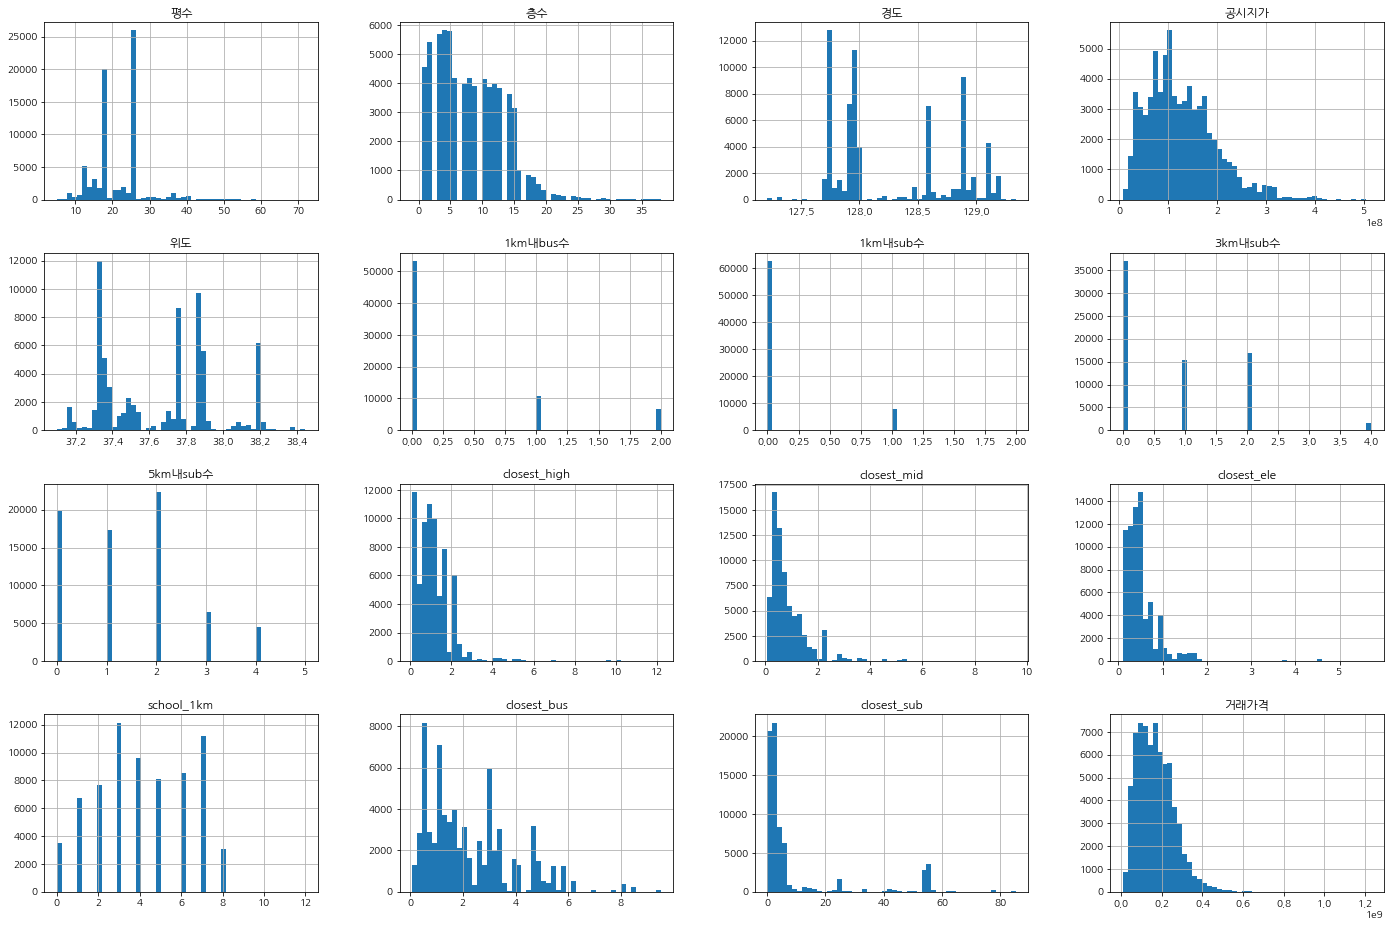

In [146]:
train_data.hist(bins=50, figsize=(24,16))
plt.rc('font', family='NanumGothic')

/home/subin/.local/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<Axes: >

/usr/lib/python3/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


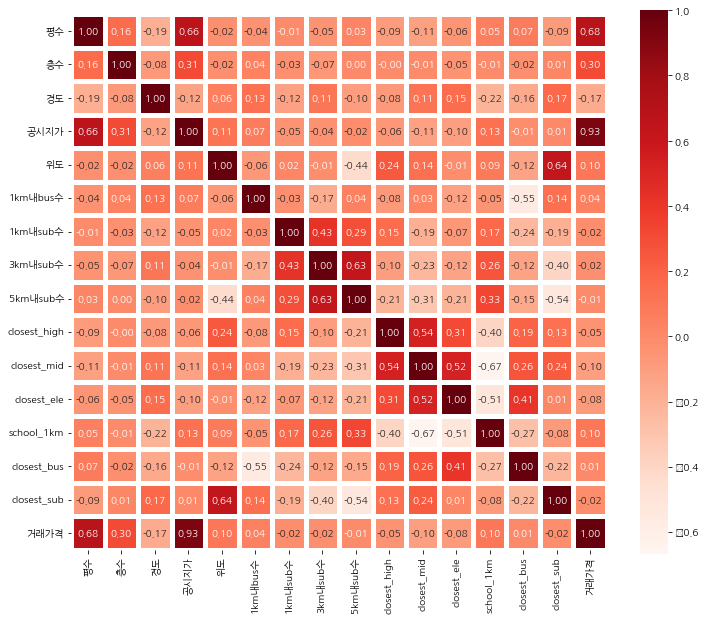

In [147]:
plt.figure(figsize=(12,10))
sns.heatmap(train_data.corr(),annot=True,square=True,fmt='.2f',linewidths=5,cmap='Reds')

In [148]:
X = main_withoutPrice.drop(['1km내sub수', '3km내sub수'], axis=1)
y = main_withPrice['거래가격']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
train_data = x_train.join(y_train)
train_data

,평수,층수,경도,공시지가,위도,1km내bus수,5km내sub수,closest_high,closest_mid,closest_ele,school_1km,closest_bus,closest_sub,거래가격
1364607,18.0,23,127.943432,178000000.0,37.348248,0.0,3.0,1.422738,0.391133,0.239138,4.0,1.094165,4.073902,236000000
1392406,23.0,14,127.923300,245000000.0,37.327129,0.0,3.0,0.130719,0.126311,0.130719,7.0,2.065639,1.255014,315000000
1299838,26.0,5,129.171217,158000000.0,37.451943,0.0,0.0,0.928204,1.370438,0.404315,3.0,1.323654,6.620925,212000000
1323606,18.0,3,128.946047,136000000.0,37.772319,0.0,1.0,2.834809,2.896060,1.559588,0.0,6.166142,4.171273,149000000
1353133,18.0,9,128.592979,161000000.0,38.188100,1.0,0.0,1.746715,2.203817,0.450576,2.0,0.565682,54.229119,260000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332395,18.0,13,127.956505,135000000.0,37.325384,0.0,2.0,1.085345,0.507948,0.360307,4.0,3.019017,3.246391,178000000
1383059,22.0,12,129.113138,128000000.0,37.520403,0.0,4.0,0.468460,1.195296,0.546886,3.0,1.139734,2.641947,186000000
1319984,18.0,4,127.717841,130000000.0,37.879897,0.0,2.0,0.507654,0.528306,0.528928,6.0,1.691842,0.522949,246000000
1364283,26.0,15,127.936822,188000000.0,37.369176,0.0,1.0,0.424936,0.424936,0.374839,3.0,2.746913,4.238769,260000000


In [149]:
train_data['층수+'] = train_data['층수']+2
train_data.drop('층수', axis=1, inplace=True)

In [150]:
from scipy.stats import boxcox
train_data[['평수']] = train_data[['평수']].apply(lambda x: boxcox(x)[0])
train_data[['closest_bus']] = np.sqrt(train_data[['closest_bus']])
train_data[['거래가격','층수+', '공시지가', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']] = np.log(train_data[['거래가격','층수+', '공시지가', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']])

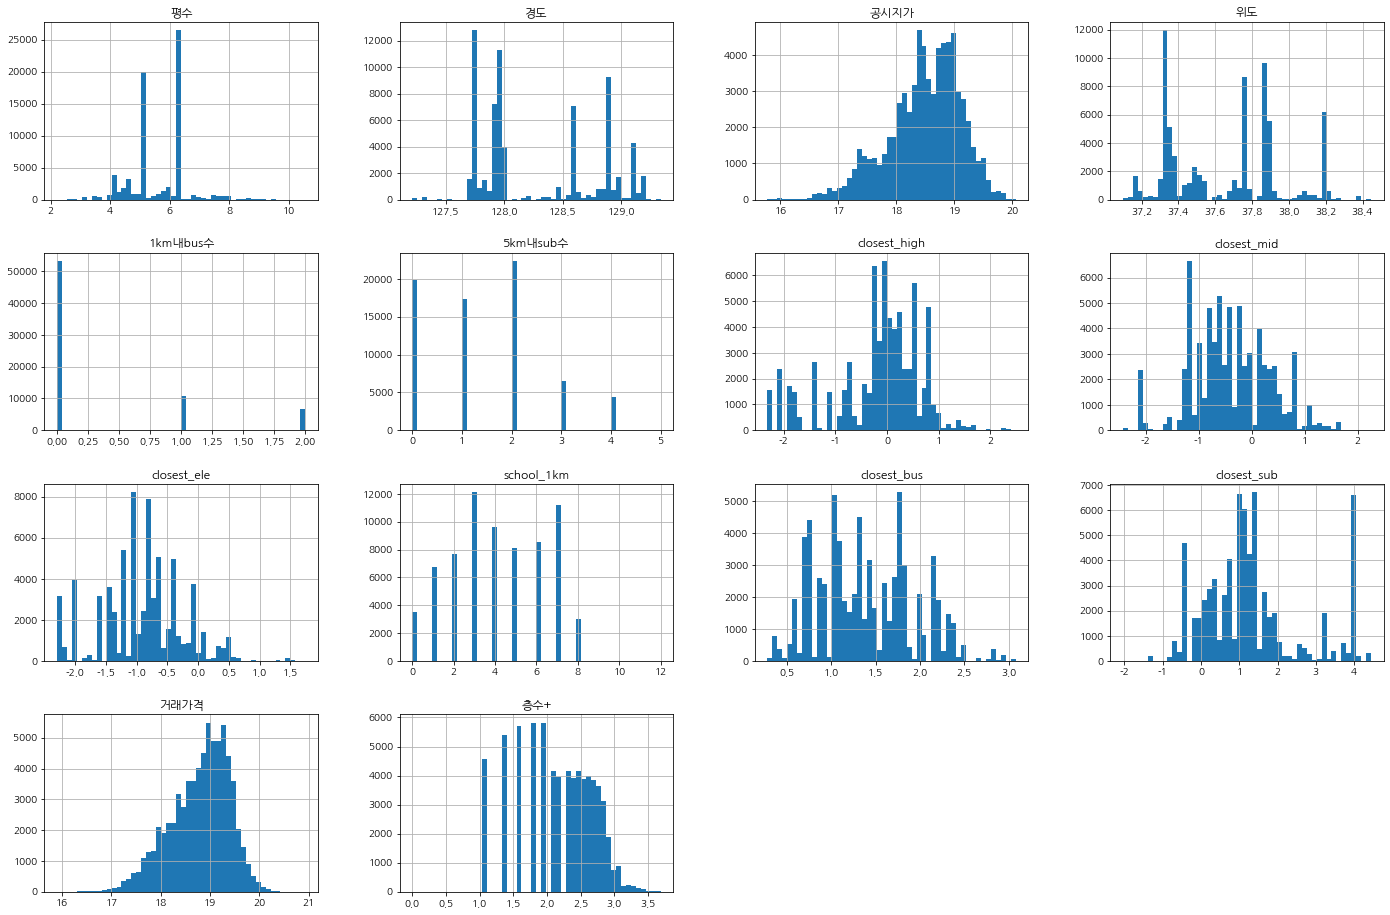

In [151]:
train_data.hist(bins=50, figsize=(24, 16))
plt.rc('font', family='NanumGothic')
plt.rc("axes", unicode_minus = False)

In [152]:
x_train, y_train = train_data.drop(['거래가격'], axis=1), train_data['거래가격']

In [153]:
valid_data = x_valid.join(y_valid)

valid_data['층수+'] = valid_data['층수']+2
valid_data.drop('층수', axis=1, inplace=True)

from scipy.stats import boxcox
valid_data[['평수']] = valid_data[['평수']].apply(lambda x: boxcox(x)[0])
valid_data[['closest_bus']] = np.sqrt(valid_data[['closest_bus']])
valid_data[['거래가격', '층수+', '공시지가', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']] = np.log(valid_data[['거래가격','층수+', '공시지가', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']])

x_valid, y_valid = valid_data.drop(['거래가격'], axis=1), valid_data['거래가격']

In [154]:
test_data = X_test.join(y_test)

test_data['층수+'] = test_data['층수']+2
test_data.drop('층수', axis=1, inplace=True)

from scipy.stats import boxcox
test_data[['평수']] = test_data[['평수']].apply(lambda x: boxcox(x)[0])
test_data[['closest_bus']] = np.sqrt(test_data[['closest_bus']])
test_data[['거래가격','층수+', '공시지가', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']] = np.log(test_data[['거래가격','층수+', '공시지가', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']])

X_test, y_test = test_data.drop(['거래가격'], axis=1), test_data['거래가격']

In [155]:
scaler = MinMaxScaler()

scaler.fit(x_train)
x_train_s = scaler.transform(x_train)
x_valid_s = scaler.transform(x_valid)
X_test_s = scaler.transform(X_test)

In [156]:
# 선형회귀모델
from sklearn.linear_model import LinearRegression
linear = LinearRegression()

linear.fit(x_train_s, y_train)

linear.score(X_test_s, y_test)

0.9099056138753037

In [158]:
y_pred_li = linear.predict(x_train_s)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

lin_R2 = r2_score(y_train, y_pred_li)
lin_mae = mean_absolute_error(y_train, y_pred_li)
print(lin_R2)
print(lin_mae)
print('--------------------')
y_pred_li = linear.predict(x_valid_s)
lin_R2 = r2_score(y_valid, y_pred_li)
lin_mae = mean_absolute_error(y_valid, y_pred_li)
print(lin_R2)
print(lin_mae)

0.9111447484504126
0.13523276233758189
--------------------
0.9122632613079276
0.1349580070444451


In [159]:
# 의사결정나무

from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
tree.fit(x_train_s, y_train)

DecisionTreeRegressor()

In [160]:
tree.score(X_test_s, y_test)

0.8896329907990675

In [161]:
y_pred_tr = tree.predict(x_train_s)

tree_R2 = r2_score(y_train, y_pred_tr)
tree_mae = mean_absolute_error(y_train, y_pred_tr)
print(tree_R2)
print(tree_mae)

0.9531124179654269
0.09013890738363


In [162]:
y_pred_tr = tree.predict(x_valid_s)

tree_R2 = r2_score(y_valid, y_pred_tr)
tree_mae = mean_absolute_error(y_valid, y_pred_tr)
print(tree_R2)
print(tree_mae)

0.9134161909094147
0.12966849389598545


In [163]:
# XGBoost 회귀

import xgboost

xgb_model = xgboost.XGBRegressor()
xgb_model.fit(x_train_s, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [164]:
y_pred_xgb = xgb_model.predict(x_train_s)

xgb_R2 = r2_score(y_train, y_pred_xgb)
xgb_mae = mean_absolute_error(y_train, y_pred_xgb)
print(xgb_R2)
print(xgb_mae)

0.9398651790210226
0.11070584859439736


In [165]:
y_pred_xgb = xgb_model.predict(x_valid_s)

xgb_R2 = r2_score(y_valid, y_pred_xgb)
xgb_mae = mean_absolute_error(y_valid, y_pred_xgb)
print(xgb_R2)
print(xgb_mae)

0.9328232509642701
0.11715018363662451


In [166]:
# k-fold 교차검증 선형회귀모델

def display_scores(model, scores):
    print('<<', model, '모델 평가 결과 >>')
    print('평균 RMSE: ', scores.mean())
    print('표준편차: ', scores.std())

from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(linear, x_valid_s, y_valid, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

display_scores('선형회귀', lin_rmse_scores)

<< 선형회귀 모델 평가 결과 >>
평균 RMSE:  0.17818537749903682
표준편차:  0.004253123012423858


In [167]:
# k-fold 교차검증 의사결정나무
tree_scores = cross_val_score(tree, x_valid_s, y_valid, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores('의사결정나무', tree_rmse_scores)

<< 의사결정나무 모델 평가 결과 >>
평균 RMSE:  0.19349245486843641
표준편차:  0.004402468592416325


In [168]:
# k-fold 교차검증 XGBoost
xgb_model_scores = cross_val_score(xgb_model, x_valid_s, y_valid, scoring='neg_mean_squared_error', cv=10)
xgb_model_rmse_scores = np.sqrt(-xgb_model_scores)
display_scores('XGBoost', xgb_model_rmse_scores)

<< XGBoost 모델 평가 결과 >>
평균 RMSE:  0.15991325621762317
표준편차:  0.003458784742523709


In [169]:
# 최종모델의 성능평가 선형회귀모델

#x_test_nor = scaler.transform(X_test)
final_pred_li = linear.predict(X_test_s)

from sklearn.metrics import mean_squared_error
final_mse_li = mean_squared_error(y_test, final_pred_li)
final_rmse_li = np.sqrt(final_mse_li)
final_r2_li = r2_score(y_test, final_pred_li)

print('RMSE: ', final_rmse_li)
print('R2: ', final_r2_li)

RMSE:  0.17656809912974222
R2:  0.9099056138753037


In [170]:
# 최종모델의 성능평가 의사결정나무

#x_test_nor = scaler.transform(X_test)
final_pred_tree = tree.predict(X_test_s)

from sklearn.metrics import mean_squared_error
final_mse_tree = mean_squared_error(y_test, final_pred_tree)
final_rmse_tree = np.sqrt(final_mse_tree)
final_r2_tree = r2_score(y_test, final_pred_tree)

print('RMSE: ', final_rmse_tree)
print('R2: ', final_r2_tree)

RMSE:  0.1954263016526183
R2:  0.8896329907990675


In [171]:
# 최종모델의 성능평가 XGBoost

#x_test_nor = scaler.transform(X_test)
final_pred_xgb_model = xgb_model.predict(X_test_s)

from sklearn.metrics import mean_squared_error
final_mse_xgb_model = mean_squared_error(y_test, final_pred_xgb_model)
final_rmse_xgb_model = np.sqrt(final_mse_xgb_model)
final_r2_xgb_model = r2_score(y_test, final_pred_xgb_model)

print('RMSE: ', final_rmse_xgb_model)
print('R2: ', final_r2_xgb_model)

RMSE:  0.17561912444036362
R2:  0.9108714456152827


In [172]:
# 예측값과 실제값의 비교 - 시각화

pred_li = pd.DataFrame(final_pred_li, columns=['예측가격'])
actual_li = pd.DataFrame(y_test)
actual_li.reset_index(inplace=True, drop=True)
table_li = pd.concat([pred_li, actual_li], axis=1)

table_li['실제거래가격'] = np.exp(table_li['거래가격'])
table_li['실제예측가격'] = np.exp(table_li['예측가격'])
table_li['오차율'] = (table_li['거래가격'] - table_li['예측가격']) / table_li['거래가격'] * 100
table_li['실제오차율'] = (table_li['실제거래가격'] - table_li['실제예측가격']) / table_li['실제거래가격'] * 100
table_li.describe()

,예측가격,거래가격,실제거래가격,실제예측가격,오차율,실제오차율
count,22057.000000,22057.000000,2.205700e+04,2.205700e+04,22057.000000,22057.000000
mean,18.780003,18.796496,1.699219e+08,1.646491e+08,0.078439,0.043773
std,0.558274,0.588265,8.982125e+07,8.238842e+07,0.944324,18.931976
min,16.259269,16.137898,1.020000e+07,1.151624e+07,-6.080482,-173.112093
25%,18.444655,18.410630,9.900000e+07,1.024264e+08,-0.436940,-8.481461
50%,18.847723,18.890684,1.600000e+08,1.532717e+08,0.145979,2.720942
75%,19.187636,19.240461,2.270000e+08,2.153201e+08,0.675345,11.996114
max,20.188796,20.455386,7.650000e+08,5.859800e+08,6.583817,72.692980


Text(0.5, 1.0, '선형회귀분석 실제오차율 분포')

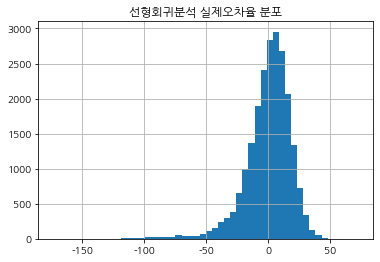

In [173]:
table_li['실제오차율'].hist(bins=50)
plt.rc("axes", unicode_minus = False)
plt.title('선형회귀분석 실제오차율 분포')

<Axes: >

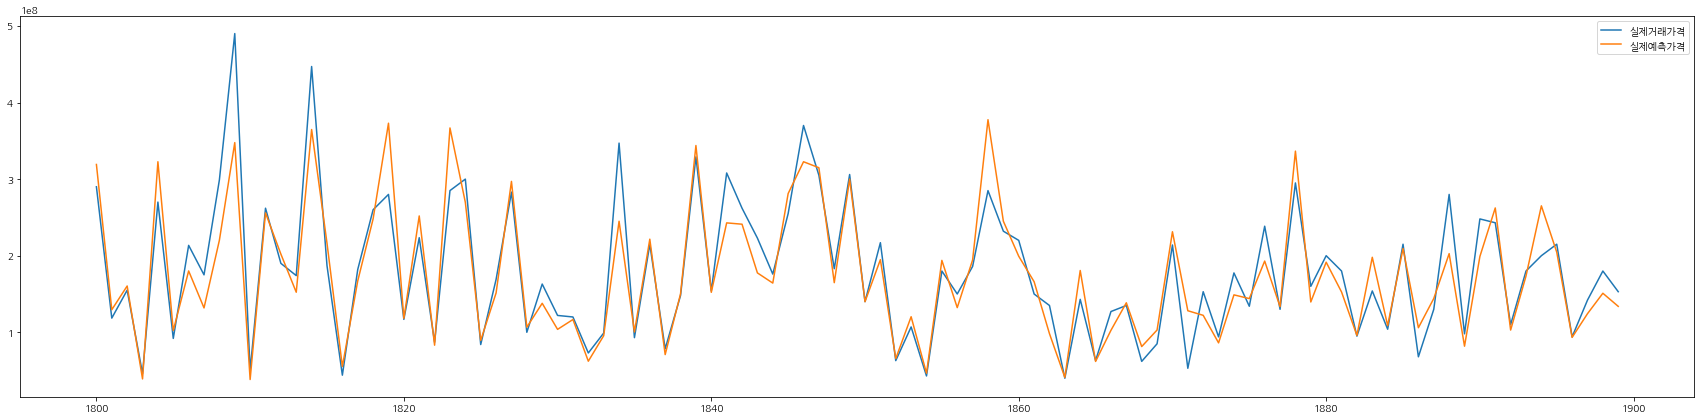

In [174]:
# 선형회귀분석 예측 정확도 시각화

real_li = table_li[['실제거래가격', '실제예측가격']]
plt.rc('font', family='NanumGothic')
real_li.iloc[1800:1900, :].plot(figsize=(30,7))

<Axes: >

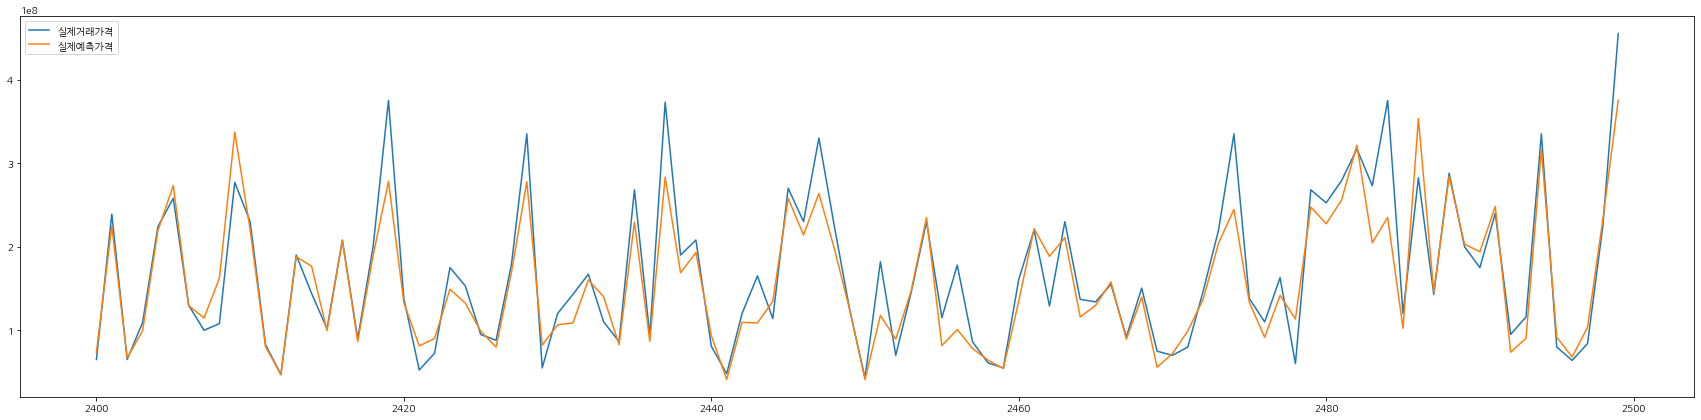

In [175]:
plt.rc('font', family='NanumGothic')
real_li.iloc[2400:2500, :].plot(figsize=(30,7))

<Axes: >

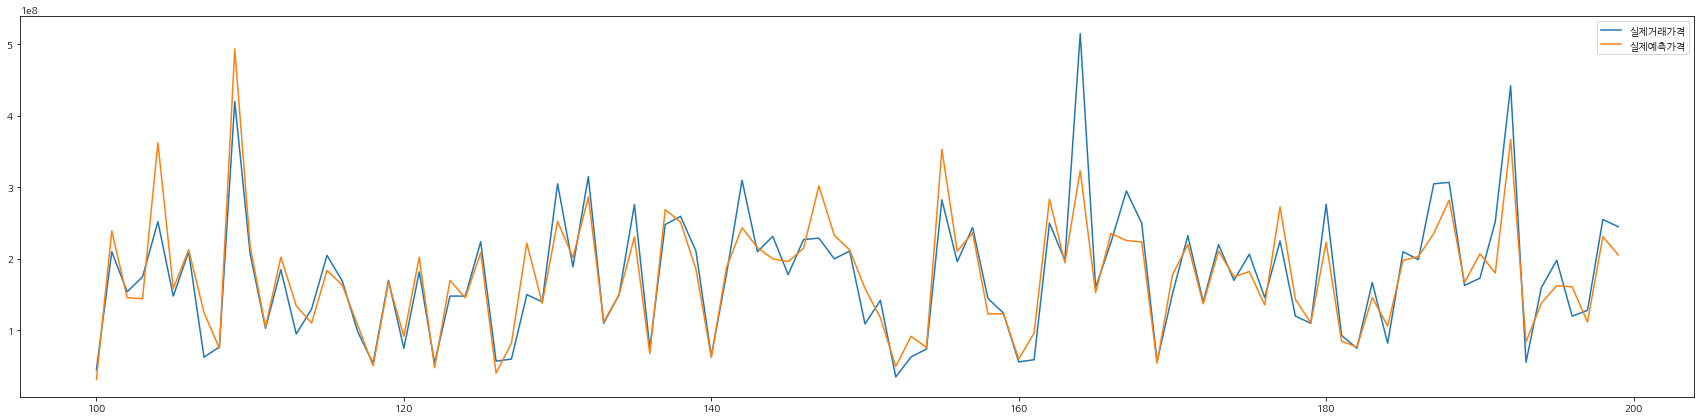

In [176]:
plt.rc('font', family='NanumGothic')
real_li.iloc[100:200, :].plot(figsize=(30,7))

In [177]:
error_li = table_li[(table_li['실제오차율']>=10)|(table_li['실제오차율']<=-10)]
error_li_only = error_li[['실제거래가격', '실제예측가격']]
error_li.describe()

,예측가격,거래가격,실제거래가격,실제예측가격,오차율,실제오차율
count,11539.000000,11539.000000,1.153900e+04,1.153900e+04,11539.000000,11539.000000
mean,18.782808,18.805098,1.746192e+08,1.660352e+08,0.101207,-0.692418
std,0.568538,0.623238,9.825577e+07,8.557144e+07,1.273509,25.603616
min,16.259269,16.137898,1.020000e+07,1.151624e+07,-6.080482,-173.112093
25%,18.457581,18.390222,9.700000e+07,1.037589e+08,-0.863511,-17.515943
50%,18.827667,18.890684,1.600000e+08,1.502284e+08,0.648681,11.518609
75%,19.185902,19.275096,2.350000e+08,2.149470e+08,1.033440,17.886131
max,20.188796,20.455386,7.650000e+08,5.859800e+08,6.583817,72.692980


<Axes: >

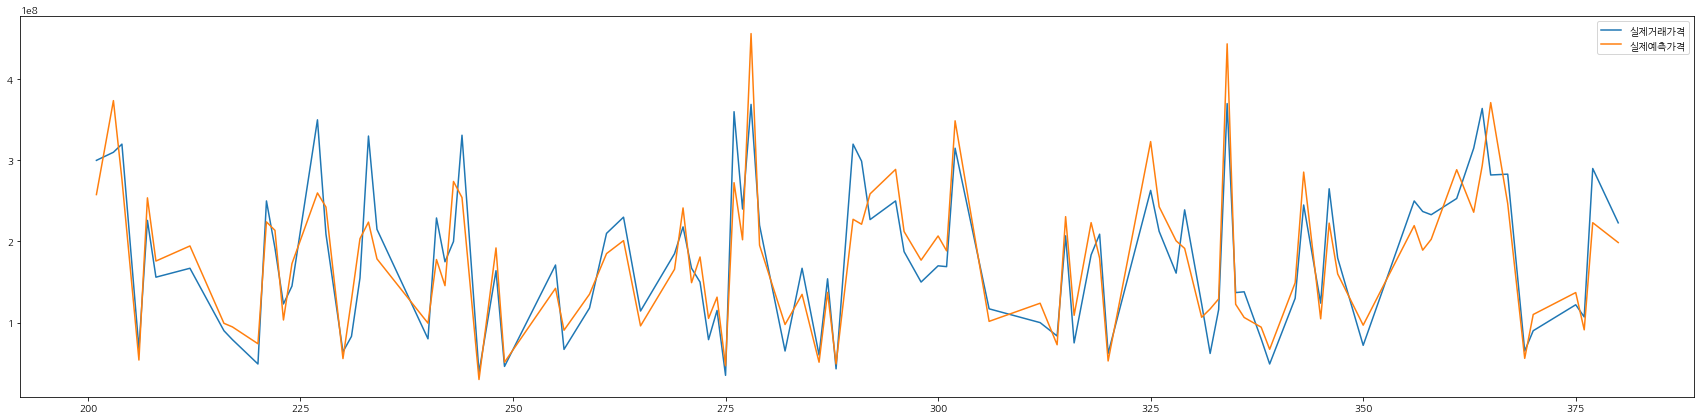

In [178]:
plt.rc('font', family='NanumGothic')
error_li_only.iloc[100:200, :].plot(figsize=(30,7))

In [179]:
# 예측값과 실제값의 비교 - 의사결정나무

pred_tree = pd.DataFrame(final_pred_tree, columns=['예측가격'])
actual_tree = pd.DataFrame(y_test)
actual_tree.reset_index(inplace=True, drop=True)
table_tree = pd.concat([pred_tree, actual_tree], axis=1)

table_tree['실제거래가격'] = np.exp(table_tree['거래가격'])
table_tree['실제예측가격'] = np.exp(table_tree['예측가격'])
table_tree['오차율'] = (table_tree['거래가격'] - table_tree['예측가격']) / table_tree['거래가격'] * 100
table_tree['실제오차율'] = (table_tree['실제거래가격'] - table_tree['실제예측가격']) / table_tree['실제거래가격'] * 100
table_tree.describe()

,예측가격,거래가격,실제거래가격,실제예측가격,오차율,실제오차율
count,22057.000000,22057.000000,2.205700e+04,2.205700e+04,22057.000000,22057.000000
mean,18.786542,18.796496,1.699219e+08,1.679320e+08,0.046767,-0.863135
std,0.583834,0.588265,8.982125e+07,8.792896e+07,1.043002,19.393233
min,16.165751,16.137898,1.020000e+07,1.048809e+07,-7.451935,-250.000000
25%,18.403362,18.410630,9.900000e+07,9.828304e+07,-0.523997,-10.322476
50%,18.864626,18.890684,1.600000e+08,1.558846e+08,0.000000,0.000000
75%,19.246899,19.240461,2.270000e+08,2.284662e+08,0.551388,9.832070
max,20.380776,20.455386,7.650000e+08,7.100000e+08,6.048659,69.654376


Text(0.5, 1.0, '의사결정나무 실제오차율 분포')

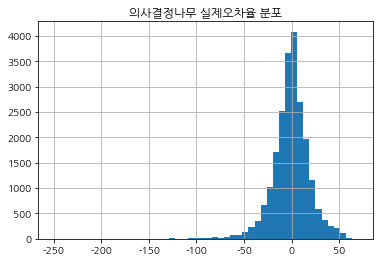

In [180]:
table_tree['실제오차율'].hist(bins=50)
plt.rc("axes", unicode_minus = False)
plt.title('의사결정나무 실제오차율 분포')

<Axes: >

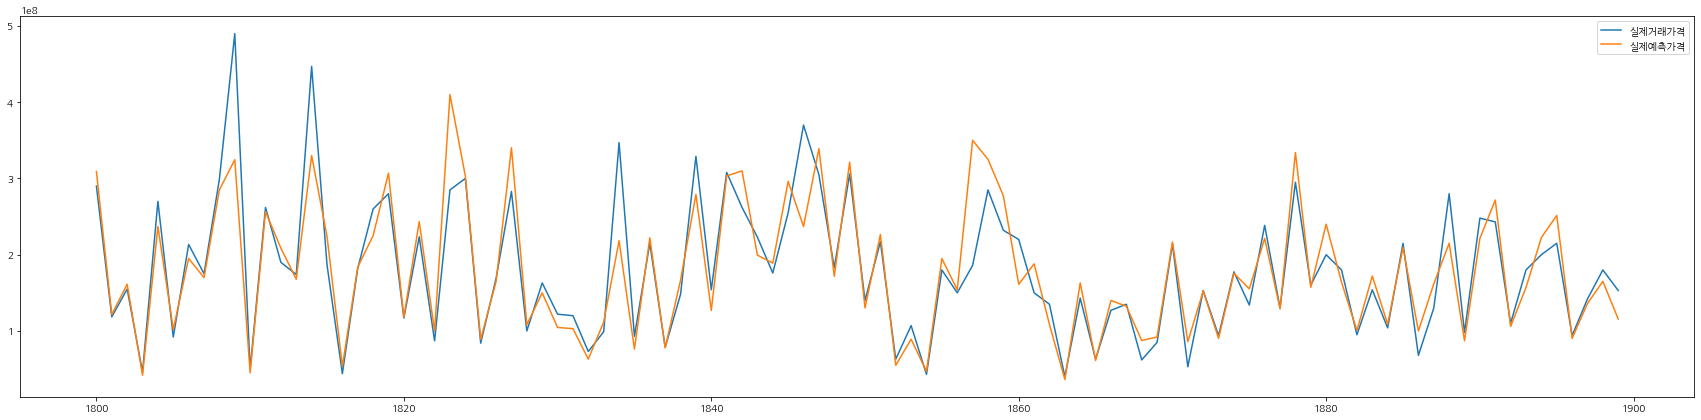

In [181]:
# 의사결정나무 예측 정확도 시각화

table_tree_only = table_tree[['실제거래가격', '실제예측가격']]
plt.rc('font', family='NanumGothic')
table_tree_only.iloc[1800:1900, :].plot(figsize=(30,7))

<Axes: >

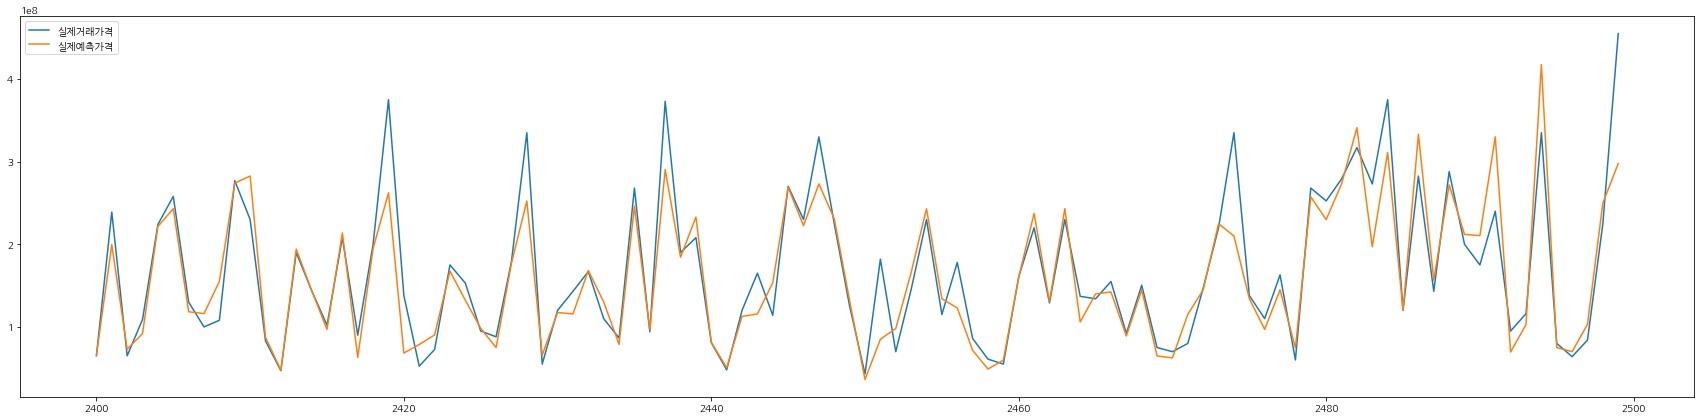

In [182]:
plt.rc('font', family='NanumGothic')
table_tree_only.iloc[2400:2500, :].plot(figsize=(30,7))

<Axes: >

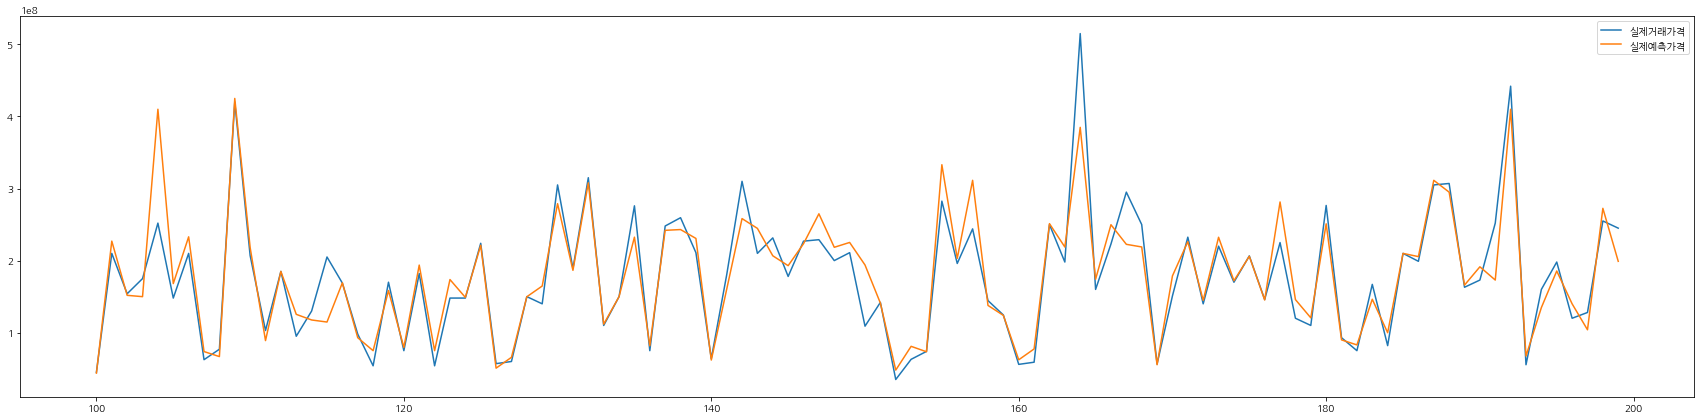

In [183]:
plt.rc('font', family='NanumGothic')
table_tree_only.iloc[100:200, :].plot(figsize=(30,7))

In [184]:
error_tree = table_tree[(table_tree['실제오차율']>=10)|(table_tree['실제오차율']<=-10)]
error_tree_only = error_tree[['실제거래가격', '실제예측가격']]
error_tree.describe()

,예측가격,거래가격,실제거래가격,실제예측가격,오차율,실제오차율
count,11122.000000,11122.000000,1.112200e+04,1.112200e+04,11122.000000,11122.000000
mean,18.744025,18.762885,1.676698e+08,1.638254e+08,0.088309,-1.659429
std,0.610132,0.620488,9.629011e+07,9.283239e+07,1.440299,26.769600
min,16.165751,16.137898,1.020000e+07,1.048809e+07,-7.451935,-250.000000
25%,18.327890,18.348110,9.300000e+07,9.113838e+07,-0.955999,-19.649453
50%,18.773210,18.826146,1.500000e+08,1.422661e+08,-0.515306,-10.215283
75%,19.239290,19.227157,2.240000e+08,2.267344e+08,1.057525,18.143006
max,20.380776,20.401682,7.250000e+08,7.100000e+08,6.048659,69.654376


<Axes: >

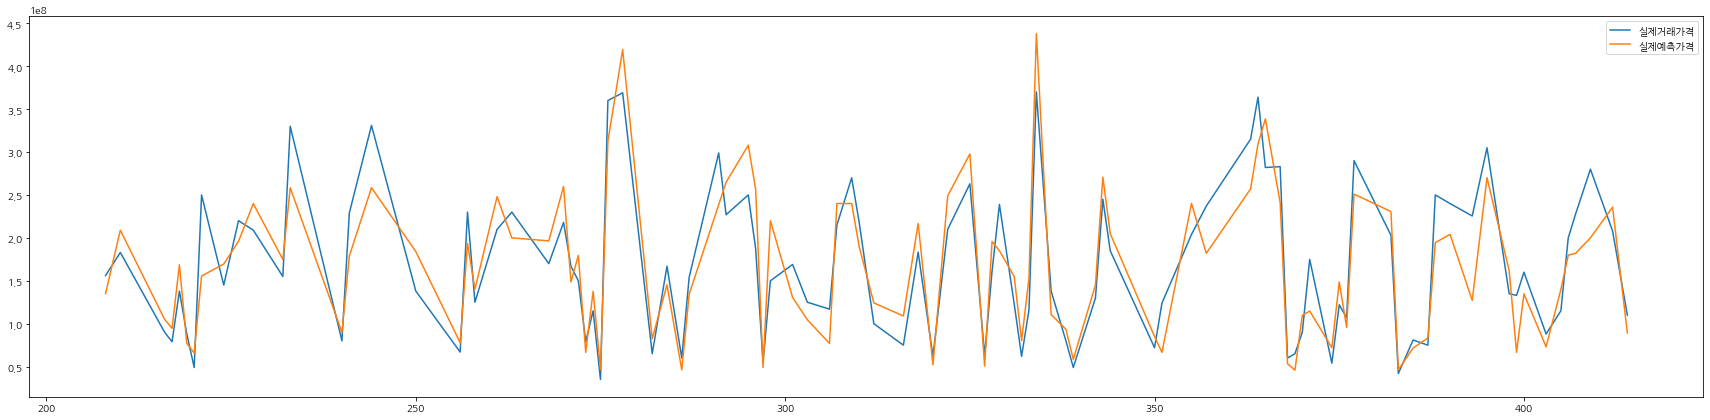

In [185]:
plt.rc('font', family='NanumGothic')
error_tree_only.iloc[100:200, :].plot(figsize=(30,7))

In [186]:
# 예측값과 실제값의 비교 - 시각화

pred_xgb_model = pd.DataFrame(final_pred_xgb_model, columns=['예측가격'])
actual_xgb_model = pd.DataFrame(y_test)
actual_xgb_model.reset_index(inplace=True, drop=True)
table_xgb_model = pd.concat([pred_xgb_model, actual_xgb_model], axis=1)

table_xgb_model['실제거래가격'] = np.exp(table_xgb_model['거래가격'])
table_xgb_model['실제예측가격'] = np.exp(table_xgb_model['예측가격'])
table_xgb_model['오차율'] = (table_xgb_model['거래가격'] - table_xgb_model['예측가격']) / table_xgb_model['거래가격'] * 100
table_xgb_model['실제오차율'] = (table_xgb_model['실제거래가격'] - table_xgb_model['실제예측가격']) / table_xgb_model['실제거래가격'] * 100
table_xgb_model.describe()

,예측가격,거래가격,실제거래가격,실제예측가격,오차율,실제오차율
count,22057.000000,22057.000000,2.205700e+04,22057.0,22057.000000,22057.000000
mean,18.768496,18.796496,1.699219e+08,163929456.0,0.141410,1.312845
std,0.568283,0.588265,8.982125e+07,84700440.0,0.923498,16.975925
min,16.212629,16.137898,1.020000e+07,10991461.0,-5.787214,-160.193093
25%,18.385206,18.410630,9.900000e+07,96514728.0,-0.402201,-7.858482
50%,18.812506,18.890684,1.600000e+08,147967856.0,0.083467,1.557420
75%,19.219196,19.240461,2.270000e+08,222223984.0,0.638733,11.370413
max,20.345194,20.455386,7.650000e+08,685181184.0,6.761179,73.631340


Text(0.5, 1.0, 'XGBoost 실제오차율 분포')

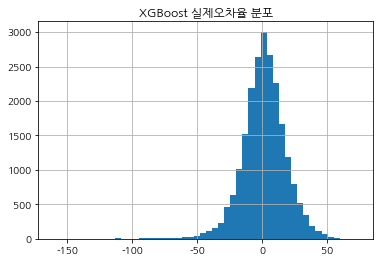

In [187]:
table_xgb_model['실제오차율'].hist(bins=50)
plt.rc("axes", unicode_minus = False)
plt.title('XGBoost 실제오차율 분포')

<Axes: >

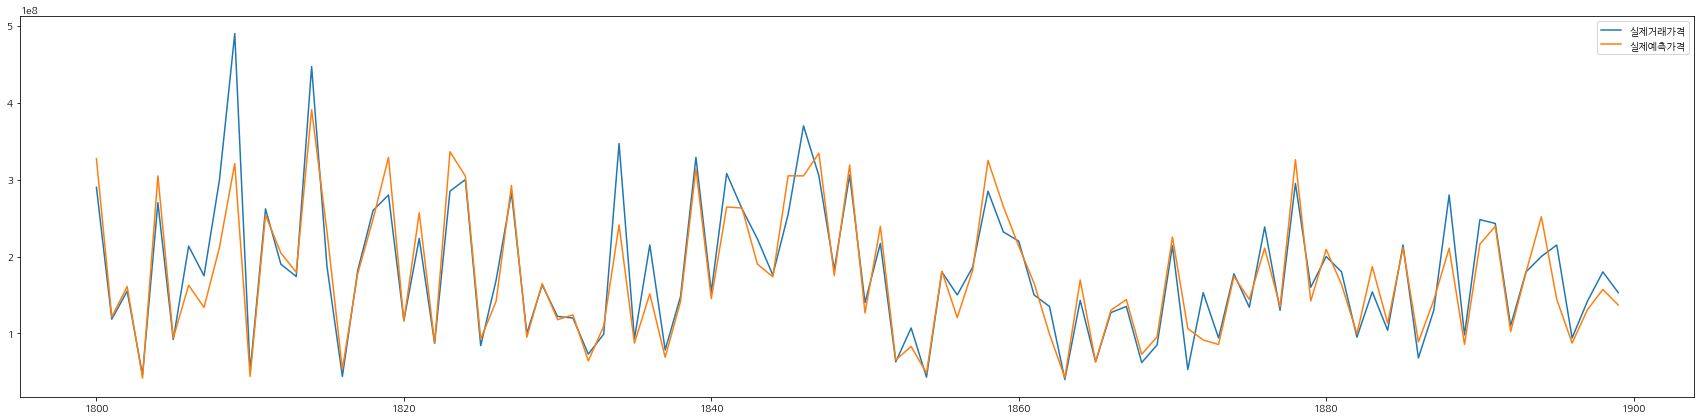

In [188]:
real_xgb_model = table_xgb_model[['실제거래가격', '실제예측가격']]
plt.rc('font', family='NanumGothic')
real_xgb_model.iloc[1800:1900, :].plot(figsize=(30,7))

In [189]:
error_xgb_model = table_xgb_model[(table_xgb_model['실제오차율']>=10)|(table_xgb_model['실제오차율']<=-10)]
error_xgb_model_only = error_xgb_model[['실제거래가격', '실제예측가격']]
error_xgb_model.describe()

,예측가격,거래가격,실제거래가격,실제예측가격,오차율,실제오차율
count,10767.000000,10767.000000,1.076700e+04,10767.0,10767.000000,10767.000000
mean,18.747450,18.800028,1.729009e+08,161137920.0,0.264248,2.373152
std,0.570913,0.614134,9.671542e+07,86424064.0,1.275123,23.581498
min,16.212629,16.137898,1.020000e+07,10991461.0,-5.787214,-160.193093
25%,18.381176,18.420681,1.000000e+08,96126536.0,-0.792410,-15.941821
50%,18.766745,18.890684,1.600000e+08,141349296.0,0.656938,11.682213
75%,19.179663,19.233831,2.255000e+08,213610048.0,1.134161,19.328284
max,20.345194,20.455386,7.650000e+08,685181184.0,6.761179,73.631340


<Axes: >

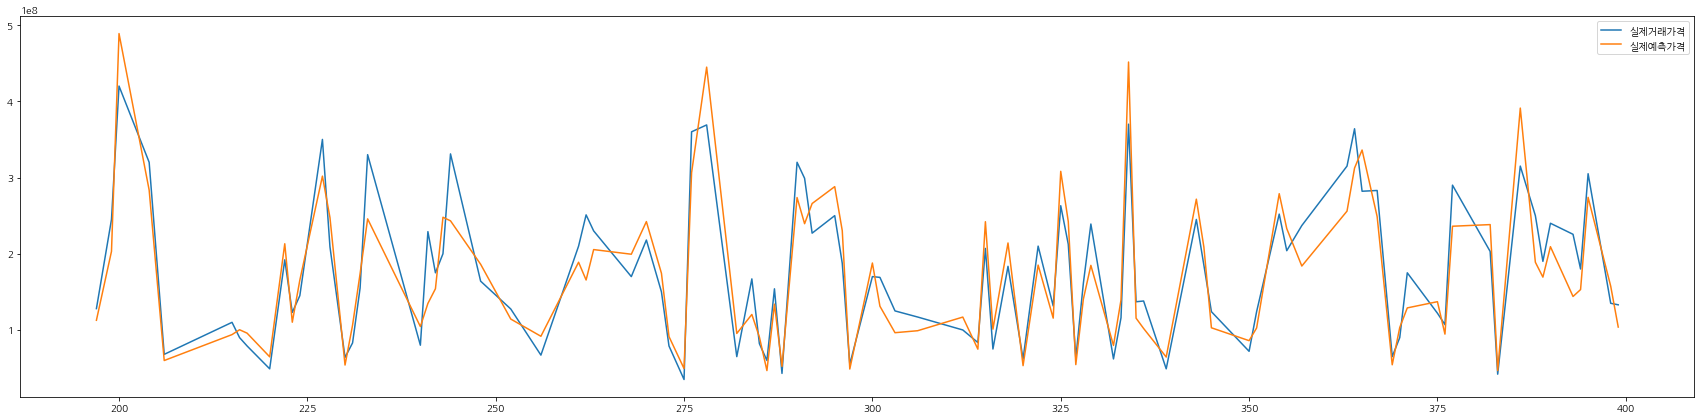

In [190]:
plt.rc('font', family='NanumGothic')
error_xgb_model_only.iloc[100:200, :].plot(figsize=(30,7))